## Install Packages

First, I will install all the necessary packages that will further be needed in the analysis

In [1]:
import requests
import numpy as np
import sqlite3
import re
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import ast
from pydoc import help
from scipy.stats.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns',85)
pd.set_option('display.max_rows',85)

## API request example

I will try requesting information from the example link given in the case to get an idea of the attributes of the information that can be fetched from the data

In [2]:
url = 'http://www.omdbapi.com/?i=tt3896198&apikey=3658de59'
r = requests.get(url)
json_data = r.json()

#Let's look at the json data as a dictionary output
for k in json_data.keys():
    print(k + ': ', json_data[k])

Title:  Guardians of the Galaxy Vol. 2
Year:  2017
Rated:  PG-13
Released:  05 May 2017
Runtime:  136 min
Genre:  Action, Adventure, Comedy, Sci-Fi
Director:  James Gunn
Writer:  James Gunn, Dan Abnett (based on the Marvel comics by), Andy Lanning (based on the Marvel comics by), Steve Englehart (Star-Lord created by), Steve Gan (Star-Lord created by), Jim Starlin (Gamora and Drax created by), Stan Lee (Groot created by), Larry Lieber (Groot created by), Jack Kirby (Groot created by), Bill Mantlo (Rocket Raccoon created by), Keith Giffen (Rocket Raccoon created by), Steve Gerber (Howard the Duck created by), Val Mayerik (Howard the Duck created by)
Actors:  Chris Pratt, Zoe Saldana, Dave Bautista, Vin Diesel
Plot:  The Guardians struggle to keep together as a team while dealing with their personal family issues, notably Star-Lord's encounter with his father the ambitious celestial being Ego.
Language:  English
Country:  USA
Awards:  Nominated for 1 Oscar. Another 12 wins & 42 nominatio

### Additional attribute fetch

- I will fetch 'Ratings' attribute to obtain Rotten Tomatoes score & Metacritic score in addition to the IMDb score provided in the database that we have.
- I will also fetch the 'Production' value to obtain the name of the Production company & 'Released' to obtain the full release date of a movie as this could be a potential factor in determining the success of a movie.
- Lastly, I will get the 'imdbID' as this is an unique id using which we can potentially join the tables later.

In [3]:
json_small = {k:v for k, v in json_data.items() if k in ('Ratings', 'imdbID', 'Production', 'Released')}
print(json_small)

{'Released': '05 May 2017', 'Ratings': [{'Source': 'Internet Movie Database', 'Value': '7.7/10'}, {'Source': 'Rotten Tomatoes', 'Value': '83%'}, {'Source': 'Metacritic', 'Value': '67/100'}], 'imdbID': 'tt3896198', 'Production': 'Walt Disney Pictures'}


### Function definition

- Create a function to fetch the JSON of the movie data from the OMDb API using IMDbId as an unique identifier and a key piece of the url to request for more information
- Create a function to get a dataframe of the information received taking into account the scenarios where the data is missing or non-existent

In [4]:
def GetJSONData(id):
    url = 'http://www.omdbapi.com/?i='+id+'&apikey=3658de59'
    r = requests.get(url)
    json_data = r.json()
    json_small = {k:v for k, v in json_data.items() if k in ('Ratings', 'imdbID', 'Production', 'Released')}
    return json_small

In [5]:
def GetMovieDataFrame(json):
    header = ['MovieId', 'Production_house', 'ReleasedDate']
    
#Since there are some rows or rather movies for which we do not have all the values, I will set this condition
# so that the function runs
    id= json['imdbID'] if (json['imdbID']) else None
    prod = json['Production'] if 'Production' in json else None
    release = json['Released'] if 'Released' in json else None
    data = [id, prod, release]
    finalTable = None
    for x in json['Ratings']:
        header.append(x['Source'])
        data.append(x['Value'])
        finalTable = pd.DataFrame(np.array([data]),columns=header)
    return finalTable

## Connect to the database file

Connect to the 'movies.db' sqlite3 database file and put the data in a dataframe for easier data manipulation, cleaning and further analysis

In [6]:
conn = sqlite3.connect('movies.db')
c = conn.cursor()

In [7]:
# Get the table name so that I can fetch the results later
c.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(c.fetchall())

[('movies',), ('movieprediction',)]


In [8]:
df = pd.read_sql_query("select * from movies;", conn)
df.head()

,id,movie_title,movie_facebook_likes,color,director_name,prolific_director,director_facebook_likes,actor_1_name,actor_2_name,actor_3_name,prolific_actor_1,prolific_actor_2,prolific_actor_3,actor_1_facebook_likes,actor_2_facebook_likes,actor_3_facebook_likes,budget,gross,genres,num_critic_for_reviews,num_voted_users,facenumber_in_poster,plot_keywords,movie_imdb_link,num_user_for_reviews,language,country,content_rating,title_year,imdb_score,oscar_nom_movie,oscar_nom_actor,duration,aspect_ratio
0,1,Intolerance: Love's Struggle Throughout the Ages,691,Black and White,D.W. Griffith,1,204,Lillian Gish,Mae Marsh,Walter Long,2,1,1,436,22,9,385907,NA,Drama|History|War,69,10718,1,huguenot|intolerance|medicis|protestant|wedding,http://www.imdb.com/title/tt0006864/?ref_=fn_t...,88,None,USA,Unrated,1916,8,0,1,123,1.33
1,2,Over the Hill to the Poorhouse,0,Black and White,Harry F. Millarde,1,0,Stephen Carr,Johnnie Walker,Mary Carr,1,1,1,2,2,0,100000,3000000,Crime|Drama,1,5,1,family relationships|gang|idler|poorhouse|thief,http://www.imdb.com/title/tt0011549/?ref_=fn_t...,1,None,USA,Missing,1920,4.8,0,0,110,1.33
2,3,The Big Parade,226,Black and White,King Vidor,3,54,John Gilbert,RenÃ©e AdorÃ©e,Claire Adams,1,1,1,81,12,6,245000,NA,Drama|Romance|War,48,4849,0,chewing gum|climbing a tree|france|translation...,http://www.imdb.com/title/tt0015624/?ref_=fn_t...,45,None,USA,Unrated,1925,8.3,0,0,151,1.33
3,4,Metropolis,12000,Black and White,Fritz Lang,1,756,Brigitte Helm,Gustav FrÃ¶hlich,Rudolf Klein-Rogge,1,1,1,136,23,18,6000000,26435,Drama|Sci-Fi,260,111841,1,art deco|bible quote|dance|silent film|worker,http://www.imdb.com/title/tt0017136/?ref_=fn_t...,413,German,Germany,Unrated,1927,8.3,0,0,145,1.33
4,5,The Broadway Melody,1718,Black and White,Harry Beaumont,1,4,Anita Page,Bessie Love,Charles King,1,1,1,1718,28,4,379000,2808000,Musical|Romance,36,4546,8,sibling rivalry|singer|sister act|whistling|wi...,http://www.imdb.com/title/tt0019729/?ref_=fn_t...,71,English,USA,PG,1929,6.3,2,1,100,1.37


### Unique Identifier

From the table above, I can see that the ids for urls we need to fetch the data from the OMDb API are stored in a column named 'movie_imdb_link' that we will further look into.

In [9]:
imdblinks = df[['movie_imdb_link']]
imdblinks.head()

,movie_imdb_link
0,http://www.imdb.com/title/tt0006864/?ref_=fn_t...
1,http://www.imdb.com/title/tt0011549/?ref_=fn_t...
2,http://www.imdb.com/title/tt0015624/?ref_=fn_t...
3,http://www.imdb.com/title/tt0017136/?ref_=fn_t...
4,http://www.imdb.com/title/tt0019729/?ref_=fn_t...


In [10]:
# Let's look at an example link
imdblinks.iloc[0, :]

movie_imdb_link    http://www.imdb.com/title/tt0006864/?ref_=fn_t...
Name: 0, dtype: object

In [11]:
#Since its an object, it needs to be converted to a string
imdblinks = str(imdblinks)

In [12]:
#Set a pattern that can extract the substring from the overall variable later.

def get_id(linkstring):
    return re.search(r'tt\d{7}', linkstring).group()

In [13]:
df['imdbid'] = df['movie_imdb_link'].apply(get_id)
df['imdbid'].head()

0    tt0006864
1    tt0011549
2    tt0015624
3    tt0017136
4    tt0019729
Name: imdbid, dtype: object

In [14]:
df.head()

,id,movie_title,movie_facebook_likes,color,director_name,prolific_director,director_facebook_likes,actor_1_name,actor_2_name,actor_3_name,prolific_actor_1,prolific_actor_2,prolific_actor_3,actor_1_facebook_likes,actor_2_facebook_likes,actor_3_facebook_likes,budget,gross,genres,num_critic_for_reviews,num_voted_users,facenumber_in_poster,plot_keywords,movie_imdb_link,num_user_for_reviews,language,country,content_rating,title_year,imdb_score,oscar_nom_movie,oscar_nom_actor,duration,aspect_ratio,imdbid
0,1,Intolerance: Love's Struggle Throughout the Ages,691,Black and White,D.W. Griffith,1,204,Lillian Gish,Mae Marsh,Walter Long,2,1,1,436,22,9,385907,NA,Drama|History|War,69,10718,1,huguenot|intolerance|medicis|protestant|wedding,http://www.imdb.com/title/tt0006864/?ref_=fn_t...,88,None,USA,Unrated,1916,8,0,1,123,1.33,tt0006864
1,2,Over the Hill to the Poorhouse,0,Black and White,Harry F. Millarde,1,0,Stephen Carr,Johnnie Walker,Mary Carr,1,1,1,2,2,0,100000,3000000,Crime|Drama,1,5,1,family relationships|gang|idler|poorhouse|thief,http://www.imdb.com/title/tt0011549/?ref_=fn_t...,1,None,USA,Missing,1920,4.8,0,0,110,1.33,tt0011549
2,3,The Big Parade,226,Black and White,King Vidor,3,54,John Gilbert,RenÃ©e AdorÃ©e,Claire Adams,1,1,1,81,12,6,245000,NA,Drama|Romance|War,48,4849,0,chewing gum|climbing a tree|france|translation...,http://www.imdb.com/title/tt0015624/?ref_=fn_t...,45,None,USA,Unrated,1925,8.3,0,0,151,1.33,tt0015624
3,4,Metropolis,12000,Black and White,Fritz Lang,1,756,Brigitte Helm,Gustav FrÃ¶hlich,Rudolf Klein-Rogge,1,1,1,136,23,18,6000000,26435,Drama|Sci-Fi,260,111841,1,art deco|bible quote|dance|silent film|worker,http://www.imdb.com/title/tt0017136/?ref_=fn_t...,413,German,Germany,Unrated,1927,8.3,0,0,145,1.33,tt0017136
4,5,The Broadway Melody,1718,Black and White,Harry Beaumont,1,4,Anita Page,Bessie Love,Charles King,1,1,1,1718,28,4,379000,2808000,Musical|Romance,36,4546,8,sibling rivalry|singer|sister act|whistling|wi...,http://www.imdb.com/title/tt0019729/?ref_=fn_t...,71,English,USA,PG,1929,6.3,2,1,100,1.37,tt0019729


## Final Movie DataFrame

Now, I will use the 2 functions that I defined earlier to fetch the data that we need using the 'imdbid' column from the 'df' DataFrame to obtain additional features that I selected earlier for all the movies in the database.

In [15]:
def MergeValue():
    idList = df['imdbid']
    jsonOutput = GetJSONData(idList[0])
    movieDataList = GetMovieDataFrame(jsonOutput)
    for id in idList[1:]:
        jsonOutput = GetJSONData(id)
        movieDataList2 = GetMovieDataFrame(jsonOutput)
        movieDataList = pd.concat([movieDataList, movieDataList2], axis=0, sort=False)
    return movieDataList

In [16]:
movieDataFrame = MergeValue()
movieDataFrame.head()

,MovieId,Production_house,ReleasedDate,Internet Movie Database,Rotten Tomatoes,Metacritic
0,tt0006864,Cohen Media Group,24 Feb 1918,8.0/10,97%,NaN
0,tt0011549,N/A,17 Sep 1920,4.7/10,NaN,NaN
0,tt0015624,MGM,N/A,8.2/10,100%,NaN
0,tt0017136,Paramount Pictures,13 Mar 1927,8.3/10,99%,98/100
0,tt0019729,MGM Home Entertainment,06 Jun 1929,6.2/10,35%,NaN


In [17]:
movieDataFrame.reset_index(drop=True)

,MovieId,Production_house,ReleasedDate,Internet Movie Database,Rotten Tomatoes,Metacritic
0,tt0006864,Cohen Media Group,24 Feb 1918,8.0/10,97%,NaN
1,tt0011549,N/A,17 Sep 1920,4.7/10,NaN,NaN
2,tt0015624,MGM,N/A,8.2/10,100%,NaN
3,tt0017136,Paramount Pictures,13 Mar 1927,8.3/10,99%,98/100
4,tt0019729,MGM Home Entertainment,06 Jun 1929,6.2/10,35%,NaN
5,tt0018737,Moviegraphs Inc.,22 Feb 1930,8.0/10,92%,NaN
6,tt0020960,Caddo,15 Nov 1930,7.7/10,76%,NaN
7,tt0022879,Gravitas,08 Dec 1932,6.5/10,92%,NaN
8,tt0024548,MCA Universal Home Video,09 Feb 1933,6.5/10,90%,NaN
9,tt0024034,MGM Home Entertainment,11 Mar 1933,7.6/10,95%,NaN


## Structure Ratings values

I will now copy the movieDataFrame into another to work on manipulating the data and get it structured. This is done to prevent any untoward changes in the original dataframe and to get it back later if needed.

In [18]:
Movie1 = pd.DataFrame.copy(movieDataFrame, deep=True)
Movie1 = Movie1.drop(['Internet Movie Database'], axis=1)
Movie1['Metacritic'] = Movie1['Metacritic'].astype(str).str.replace('/100','')
Movie1['Rotten Tomatoes'] = Movie1['Rotten Tomatoes'].astype(str).str.replace('%','')
Movie1.head()

,MovieId,Production_house,ReleasedDate,Rotten Tomatoes,Metacritic
0,tt0006864,Cohen Media Group,24 Feb 1918,97,nan
0,tt0011549,N/A,17 Sep 1920,nan,nan
0,tt0015624,MGM,N/A,100,nan
0,tt0017136,Paramount Pictures,13 Mar 1927,99,98
0,tt0019729,MGM Home Entertainment,06 Jun 1929,35,nan


## Replace values and types

I can see that couple of columns have a string added 'nan' instead of the value NaN so we will replace that and also change the types of the variables to get them in proper shape.

In [19]:
Movie1['Metacritic'][Movie1['Metacritic'] == 'nan'] = None
Movie1['Rotten Tomatoes'][Movie1['Rotten Tomatoes'] == 'nan'] = None
Movie1['Metacritic'] = Movie1['Metacritic'].astype(float)
Movie1['Rotten Tomatoes'] = Movie1['Rotten Tomatoes'].astype(float)
Movie1.describe()

,Rotten Tomatoes,Metacritic
count,4180.000000,3901.000000
mean,55.473445,54.872084
std,27.927315,18.457027
min,0.000000,1.000000
25%,32.000000,41.000000
50%,57.000000,55.000000
75%,81.000000,68.000000
max,100.000000,100.000000


Since the index has been set to 0 for each row, I will reset it to back to the default

In [20]:
Movie1.reset_index(drop=True)

,MovieId,Production_house,ReleasedDate,Rotten Tomatoes,Metacritic
0,tt0006864,Cohen Media Group,24 Feb 1918,97.0,NaN
1,tt0011549,N/A,17 Sep 1920,NaN,NaN
2,tt0015624,MGM,N/A,100.0,NaN
3,tt0017136,Paramount Pictures,13 Mar 1927,99.0,98.0
4,tt0019729,MGM Home Entertainment,06 Jun 1929,35.0,NaN
5,tt0018737,Moviegraphs Inc.,22 Feb 1930,92.0,NaN
6,tt0020960,Caddo,15 Nov 1930,76.0,NaN
7,tt0022879,Gravitas,08 Dec 1932,92.0,NaN
8,tt0024548,MCA Universal Home Video,09 Feb 1933,90.0,NaN
9,tt0024034,MGM Home Entertainment,11 Mar 1933,95.0,NaN


## Merge DataFrames

Now I will merge the movies database dataframe and the new attributes table fetched from the OMDb database to obtain a new comprehensive dataframe with all the attributes to further enable analysis.

In [21]:
Mf = pd.merge(df, Movie1, left_on='imdbid', right_on='MovieId')

In [22]:
Mf.shape

(4638, 40)

In [23]:
Mf.columns

Index(['id', 'movie_title', 'movie_facebook_likes', 'color', 'director_name',
       'prolific_director', 'director_facebook_likes', 'actor_1_name',
       'actor_2_name', 'actor_3_name', 'prolific_actor_1', 'prolific_actor_2',
       'prolific_actor_3', 'actor_1_facebook_likes', 'actor_2_facebook_likes',
       'actor_3_facebook_likes', 'budget', 'gross', 'genres',
       'num_critic_for_reviews', 'num_voted_users', 'facenumber_in_poster',
       'plot_keywords', 'movie_imdb_link', 'num_user_for_reviews', 'language',
       'country', 'content_rating', 'title_year', 'imdb_score',
       'oscar_nom_movie', 'oscar_nom_actor', 'duration', 'aspect_ratio',
       'imdbid', 'MovieId', 'Production_house', 'ReleasedDate',
       'Rotten Tomatoes', 'Metacritic'],
      dtype='object')

In [24]:
Mf.head()

,id,movie_title,movie_facebook_likes,color,director_name,prolific_director,director_facebook_likes,actor_1_name,actor_2_name,actor_3_name,prolific_actor_1,prolific_actor_2,prolific_actor_3,actor_1_facebook_likes,actor_2_facebook_likes,actor_3_facebook_likes,budget,gross,genres,num_critic_for_reviews,num_voted_users,facenumber_in_poster,plot_keywords,movie_imdb_link,num_user_for_reviews,language,country,content_rating,title_year,imdb_score,oscar_nom_movie,oscar_nom_actor,duration,aspect_ratio,imdbid,MovieId,Production_house,ReleasedDate,Rotten Tomatoes,Metacritic
0,1,Intolerance: Love's Struggle Throughout the Ages,691,Black and White,D.W. Griffith,1,204,Lillian Gish,Mae Marsh,Walter Long,2,1,1,436,22,9,385907,NA,Drama|History|War,69,10718,1,huguenot|intolerance|medicis|protestant|wedding,http://www.imdb.com/title/tt0006864/?ref_=fn_t...,88,None,USA,Unrated,1916,8,0,1,123,1.33,tt0006864,tt0006864,Cohen Media Group,24 Feb 1918,97.0,NaN
1,2,Over the Hill to the Poorhouse,0,Black and White,Harry F. Millarde,1,0,Stephen Carr,Johnnie Walker,Mary Carr,1,1,1,2,2,0,100000,3000000,Crime|Drama,1,5,1,family relationships|gang|idler|poorhouse|thief,http://www.imdb.com/title/tt0011549/?ref_=fn_t...,1,None,USA,Missing,1920,4.8,0,0,110,1.33,tt0011549,tt0011549,N/A,17 Sep 1920,NaN,NaN
2,3,The Big Parade,226,Black and White,King Vidor,3,54,John Gilbert,RenÃ©e AdorÃ©e,Claire Adams,1,1,1,81,12,6,245000,NA,Drama|Romance|War,48,4849,0,chewing gum|climbing a tree|france|translation...,http://www.imdb.com/title/tt0015624/?ref_=fn_t...,45,None,USA,Unrated,1925,8.3,0,0,151,1.33,tt0015624,tt0015624,MGM,N/A,100.0,NaN
3,4,Metropolis,12000,Black and White,Fritz Lang,1,756,Brigitte Helm,Gustav FrÃ¶hlich,Rudolf Klein-Rogge,1,1,1,136,23,18,6000000,26435,Drama|Sci-Fi,260,111841,1,art deco|bible quote|dance|silent film|worker,http://www.imdb.com/title/tt0017136/?ref_=fn_t...,413,German,Germany,Unrated,1927,8.3,0,0,145,1.33,tt0017136,tt0017136,Paramount Pictures,13 Mar 1927,99.0,98.0
4,5,The Broadway Melody,1718,Black and White,Harry Beaumont,1,4,Anita Page,Bessie Love,Charles King,1,1,1,1718,28,4,379000,2808000,Musical|Romance,36,4546,8,sibling rivalry|singer|sister act|whistling|wi...,http://www.imdb.com/title/tt0019729/?ref_=fn_t...,71,English,USA,PG,1929,6.3,2,1,100,1.37,tt0019729,tt0019729,MGM Home Entertainment,06 Jun 1929,35.0,NaN


In [25]:
print(Mf.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4638 entries, 0 to 4637
Data columns (total 40 columns):
id                         4638 non-null int64
movie_title                4638 non-null object
movie_facebook_likes       4638 non-null object
color                      4638 non-null object
director_name              4638 non-null object
prolific_director          4638 non-null object
director_facebook_likes    4638 non-null object
actor_1_name               4638 non-null object
actor_2_name               4638 non-null object
actor_3_name               4638 non-null object
prolific_actor_1           4638 non-null object
prolific_actor_2           4638 non-null object
prolific_actor_3           4638 non-null object
actor_1_facebook_likes     4638 non-null object
actor_2_facebook_likes     4638 non-null object
actor_3_facebook_likes     4638 non-null object
budget                     4638 non-null object
gross                      4638 non-null object
genres                     463

In [26]:
Mf['plot_keywords'].tail()

4633                         cia|mole|revolution|spy|ussr
4634    opec|pubic hair|revolutionary|terrorism|true c...
4635    coastal town|iceland|police|snowstorm|winter s...
4636                                                     
4637    based on true story|blood|serial killer|slashe...
Name: plot_keywords, dtype: object

## Change column types

Change some column types to numeric from object as the data is numeric in nature.

In [27]:
numcols = ['movie_facebook_likes', 'prolific_director', 'director_facebook_likes', 'actor_1_facebook_likes', 
           'actor_2_facebook_likes', 'actor_3_facebook_likes', 'budget', 'gross', 'num_critic_for_reviews',
           'num_voted_users', 'facenumber_in_poster', 'num_user_for_reviews', 'imdb_score', 'duration', 
           'Rotten Tomatoes', 'Metacritic']
Mf[numcols] = Mf[numcols].apply(pd.to_numeric, errors='coerce', axis=1)

In [28]:
Mf = Mf.drop(['imdbid', 'id', 'movie_imdb_link'], axis=1)

In [29]:
# Calculated a new variable called return which is a ratio of the gross revenue and the budget values.
Mf['return'] = Mf['gross'] / Mf['budget']
Mf[Mf['return'].isnull()].shape

(969, 38)

# Histogram plot

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a24f4d748>,
      dtype=object)

<Figure size 432x288 with 0 Axes>

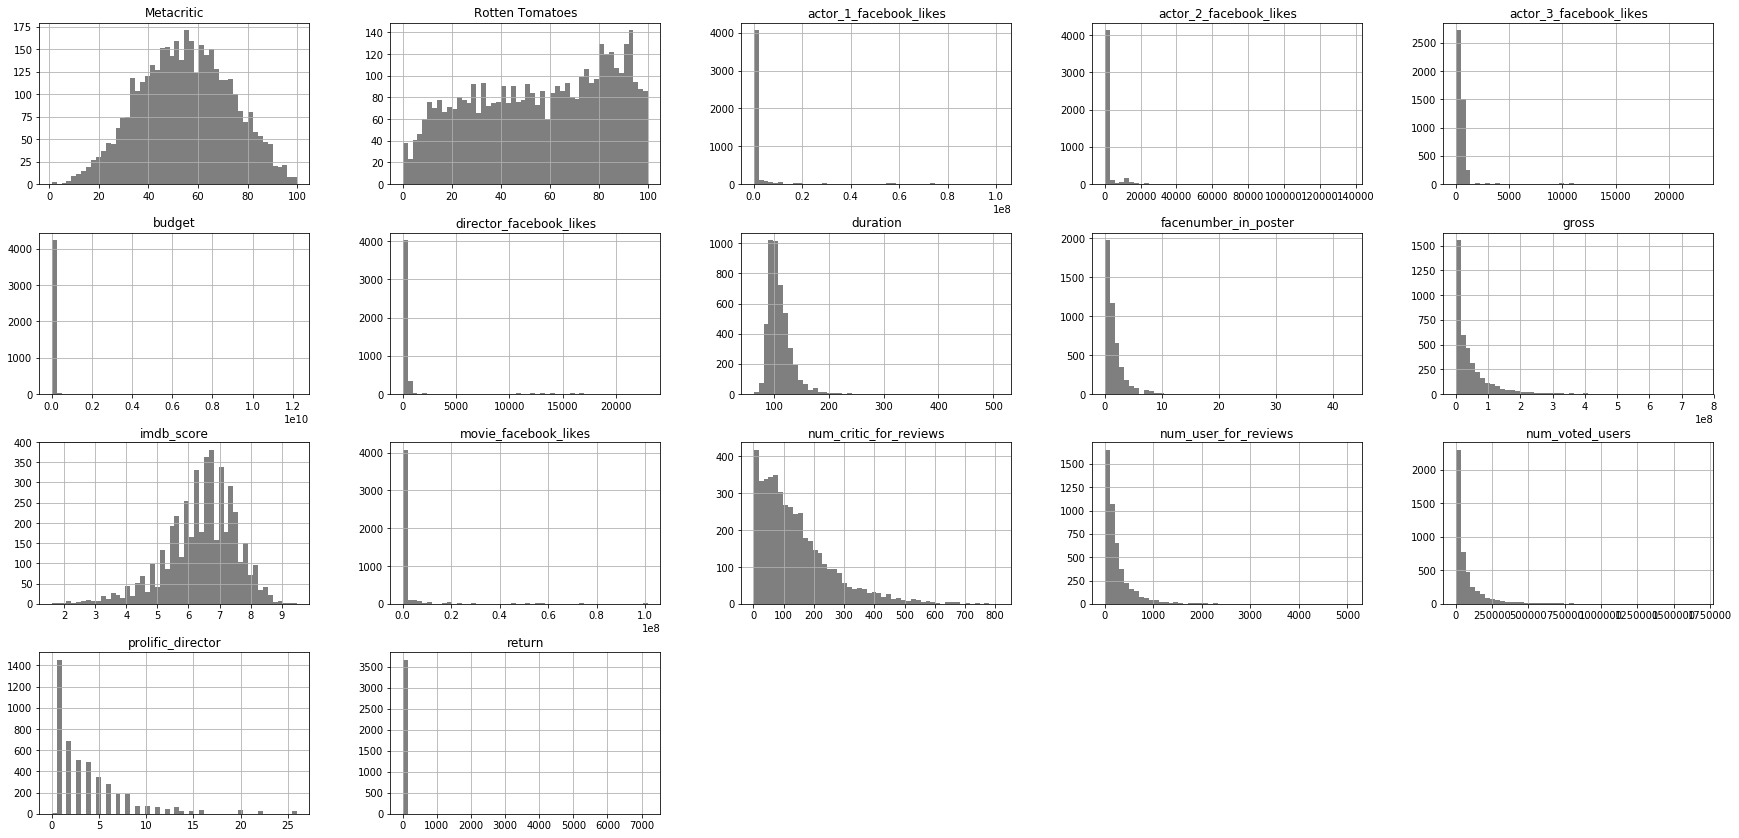

In [30]:
plt.figure()
Mf.hist(layout = (8,5), color = 'k', alpha=0.5, bins=50, figsize = (30,30))

In [31]:
# removing return as it has no variance
Mf = Mf.drop('return', axis = 1)

## Correlation Matrix

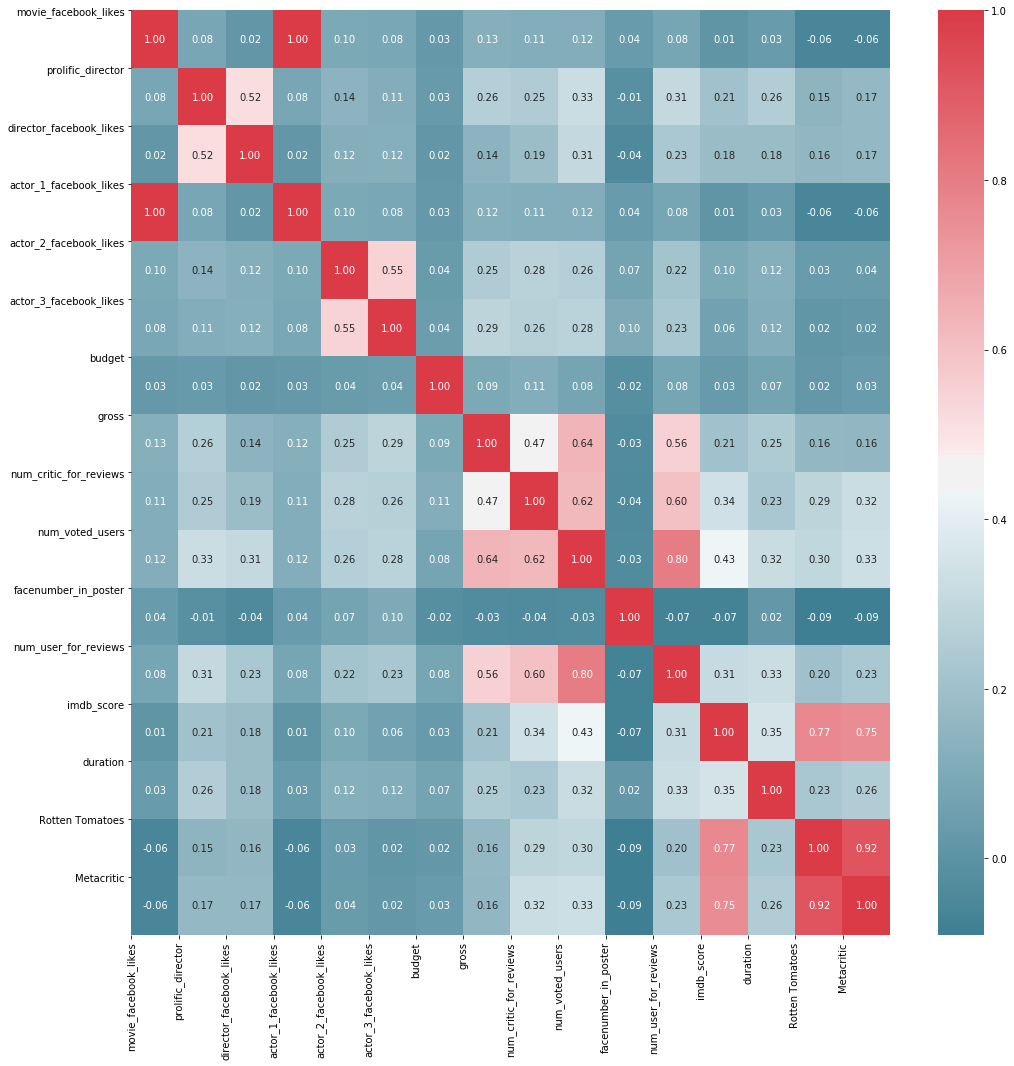

In [32]:
corr = Mf.corr()
fig, ax = plt.subplots(figsize=(17, 17))
#Generate Color Map
colormap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, cmap=colormap, annot=True, fmt=".2f")
#Apply xticks
plt.xticks(range(len(corr.columns)), corr.columns);
#Apply yticks
plt.yticks(range(len(corr.columns)), corr.columns)
#show plot
plt.show()

### Insights from correlation data
1) The "movie_facebook_likes" has strong correlation with "actor_1_facebook_likes", meaning that the popularity of a movie in social network can be largely affected by the main actor  
2) The "movie_facebook_likes" has positive correlation with "gross", meaning that the more likes on social media directly affects the gross box office earnings of a movie as many people would have watched it.  
3) The "movie_facebook_likes" has positive correlation with "num_critic_for_reviews", and "num_voted_users" meaning that the popularity of a movie in social network can be largely affected by the critics and voted users.  
4) The "gross" has strong positive correlation with the "profilic director"  
5) The "imdb_score" has very small but positive correlation with the "director_facebook_likes","profilic director"   meaning a popular director who has done many movies does not necessarily mean his directed movie is great.  
6) The "imdb_score" has small but positive correlation with "duration". Long movies tend to have high rating.  
7) The "imdb_score" has small but negative correlation with "facenumber_in_poster". It is perhaps not a good idea to have many faces in movie poster if a movie wants to be great.  
8) The "imdb_score" has almost no correlation with "budget". Throwing money at a movie will not necessarily make it great.  
9) The "imdb_score" has almost no correlation with the "actor_1_facebook_likes","movie_facebook_likes" meaning that an actor/movie is popular in social network does not mean that a movie is high rating. So there is no relation between popularity and imdb score. 

# Exploratory Data Analysis

__Color__:

In [33]:
Mf['color'].value_counts(normalize=True)

Color               0.955153
 Black and White    0.041613
Missing             0.003234
Name: color, dtype: float64

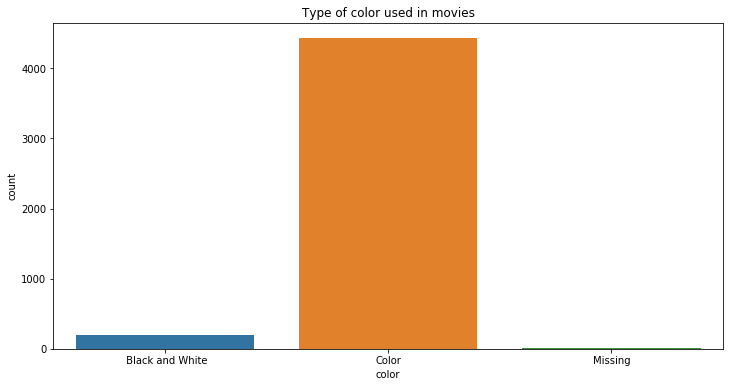

In [34]:
plt.figure(figsize=(12,6))
plt.title("Type of color used in movies")
sns.countplot(x='color', data=Mf)

From above, we can see that most of the films are "Color" in nature while there are some missing values for which we will deal with later. The number of color films is so high that it dwarves the ones made in Black and white.

__Language__:

In [35]:
Mf['language'].value_counts(normalize=True)

English       0.937904
French        0.013799
Spanish       0.007978
Hindi         0.005821
Mandarin      0.004528
German        0.003665
Japanese      0.002587
Russian       0.002156
Cantonese     0.002156
Italian       0.001725
Portuguese    0.001725
Korean        0.001509
Arabic        0.001078
Hebrew        0.001078
None          0.001078
Danish        0.000862
Norwegian     0.000862
Persian       0.000862
Dutch         0.000647
Chinese       0.000647
Swedish       0.000647
Icelandic     0.000431
Aboriginal    0.000431
Dari          0.000431
Zulu          0.000431
Thai          0.000431
Indonesian    0.000431
Vietnamese    0.000216
Greek         0.000216
Kazakh        0.000216
Romanian      0.000216
Bosnian       0.000216
Aramaic       0.000216
Panjabi       0.000216
Czech         0.000216
Kannada       0.000216
Hungarian     0.000216
Mongolian     0.000216
Slovenian     0.000216
Maya          0.000216
Telugu        0.000216
Tamil         0.000216
Polish        0.000216
Urdu       

In [36]:
Mf['language'].describe()

count        4638
unique         46
top       English
freq         4350
Name: language, dtype: object

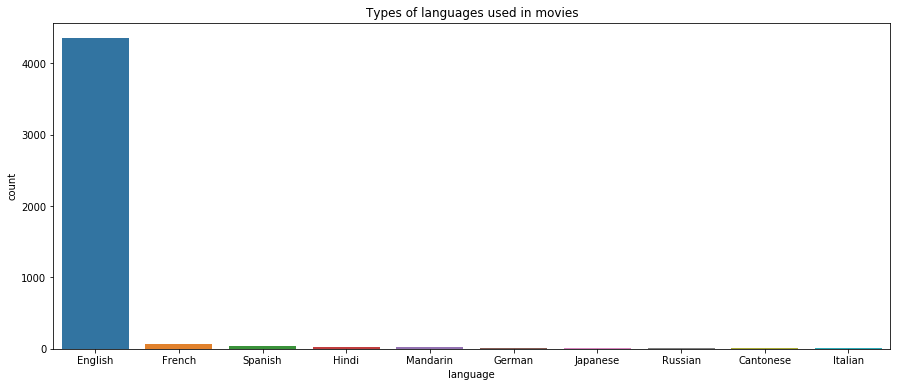

In [37]:
plt.figure(figsize=(15,6))
plt.title("Types of languages used in movies")
sns.countplot(x='language', data=Mf, order=Mf.language.value_counts().iloc[:10].index)

There are 46 languages in the data but since the number of movies made in English is so high at 4350, the numbers don't even come close with most of the foreign-language movies having less than 5 movies in the entire dataset

__Country__:

In [38]:
Mf['country'].describe()

count     4638
unique      62
top        USA
freq      3521
Name: country, dtype: object

In [39]:
Mf['country'].value_counts(normalize=True)

USA                     0.759163
UK                      0.087322
France                  0.031263
Canada                  0.024795
Germany                 0.019405
Australia               0.010565
Spain                   0.007115
India                   0.007115
China                   0.005390
Italy                   0.004312
Japan                   0.003665
Hong Kong               0.003450
Mexico                  0.003019
New Zealand             0.002803
South Korea             0.002803
Ireland                 0.002587
Russia                  0.002156
Denmark                 0.002156
Brazil                  0.001725
South Africa            0.001725
Norway                  0.001509
Iran                    0.000862
Sweden                  0.000862
Thailand                0.000862
Netherlands             0.000862
Israel                  0.000862
Argentina               0.000862
West Germany            0.000647
Switzerland             0.000647
Belgium                 0.000647
Czech Repu

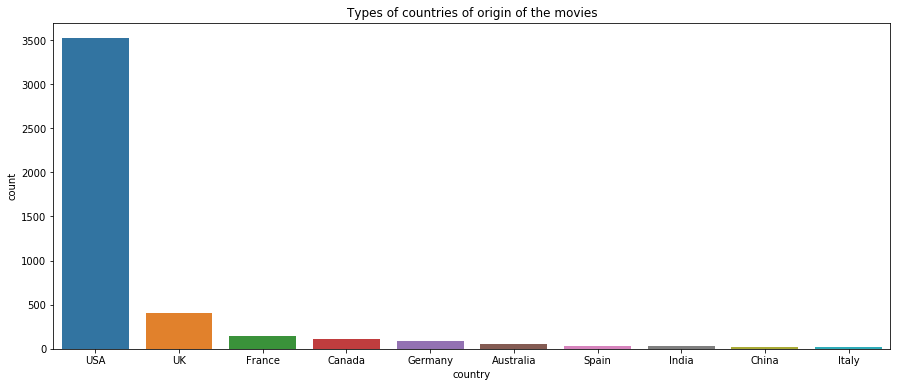

In [40]:
plt.figure(figsize=(15,6))
plt.title("Types of countries of origin of the movies")
sns.countplot(x='country', data=Mf, order=Mf.country.value_counts().iloc[:10].index)

There are 62 countries of origin in the data but since the number of movies made in the USA is so high at 4350, the numbers don't even come close with most of the other countries movies having less than 5 movies in the entire dataset

__Content Rating__:

In [41]:
Mf['content_rating'].value_counts(normalize=True)

R           0.432514
PG-13       0.295170
PG          0.146399
Missing     0.052609
Unrated     0.035576
G           0.023070
Approved    0.010781
X           0.002372
NC-17       0.001509
Name: content_rating, dtype: float64

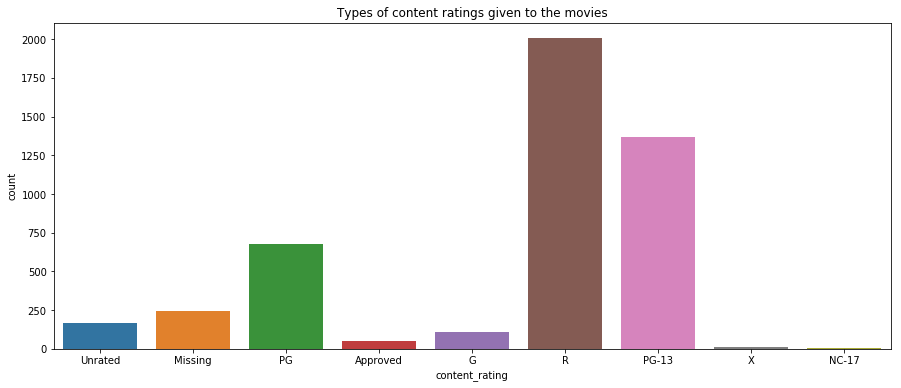

In [42]:
plt.figure(figsize=(15,6))
plt.title("Types of content ratings given to the movies")
sns.countplot(x='content_rating', data=Mf)

From above, we can see that most movies have a R rating and the 2nd highest category is PG-13 while there are very few X & NC-17 rated movies

__Aspect Ratio__:

In [43]:
Mf['aspect_ratio'].value_counts(normalize=True)

2.35       0.477792
1.85       0.387667
Missing    0.061449
1.37       0.020267
1.78       0.017896
1.66       0.012505
1.33       0.008624
2.2        0.003019
16         0.003019
2.39       0.002803
2          0.001078
1.75       0.000647
2.4        0.000647
2.76       0.000431
2.55       0.000431
1.5        0.000431
2.24       0.000216
1.77       0.000216
1.18       0.000216
4          0.000216
1.2        0.000216
1.89       0.000216
Name: aspect_ratio, dtype: float64

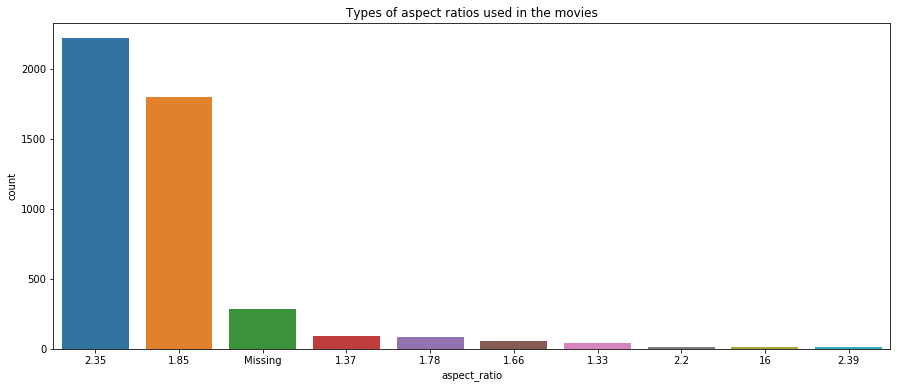

In [44]:
plt.figure(figsize=(15,6))
plt.title("Types of aspect ratios used in the movies")
sns.countplot(x='aspect_ratio', data=Mf, order=Mf.aspect_ratio.value_counts().iloc[:10].index)

From above, we can see that most of the movies use 2.35 or 1.35 aspect ratios. There are some missing values that we will deal with later. There are almost 22 types of ratios but many have negligible count.

## Text Analysis

Now, I will analyze the movie titles and the plot keywords to see which key words have the most frequency

In [45]:
Mf['movie_title'] = Mf['movie_title'].astype('str')
Mf['plot_keywords'] = Mf['plot_keywords'].astype('str')

In [46]:
title_corpus = ' '.join(Mf['movie_title'])
key_corpus = ' '.join(Mf['plot_keywords'])

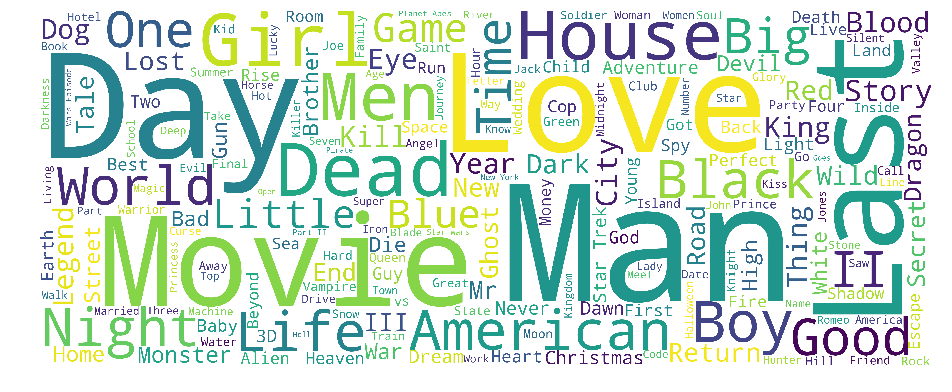

In [47]:
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=2000, width=5000).generate(title_corpus)
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

From above, I can see that the top key words are - 'Love', 'Man', 'Day', 'Movie', 'Last', 'Girl','Dead' signifying that we have a lot of Drama/ Romantic movies as well as horror movies. We can confirm this after looking at the genres variable in detail later.

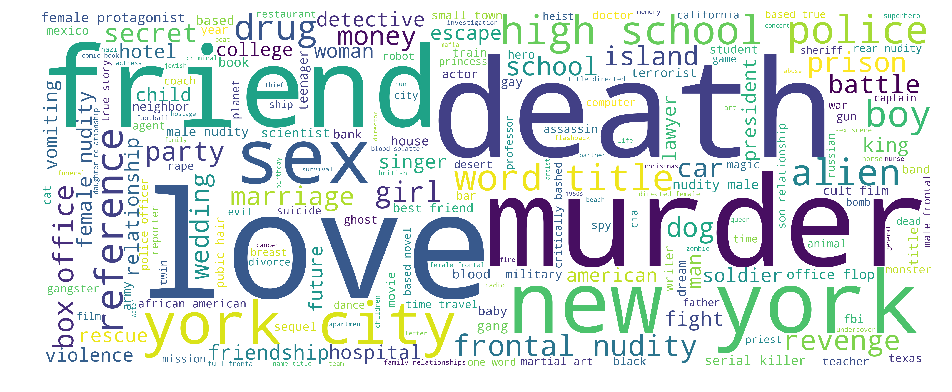

In [48]:
key_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=2000, width=5000).generate(key_corpus)
plt.figure(figsize=(16,8))
plt.imshow(key_wordcloud)
plt.axis('off')
plt.show()

The above wordcloud of plotwords shows the key words as - 'Love', 'murder', 'friend', 'death', 'new york' & 'york city' confirming the fact that we have a lot of movies in English and originating in the USA where 'New York City' plays a big role in majority of them. Also, words like love and death probably refer to romance and thriller/ horror movies in the data

__IMDb Score:__

In [49]:
Mf['imdb_score'].describe()

count    4638.000000
mean        6.410673
std         1.118078
min         1.600000
25%         5.800000
50%         6.500000
75%         7.200000
max         9.500000
Name: imdb_score, dtype: float64

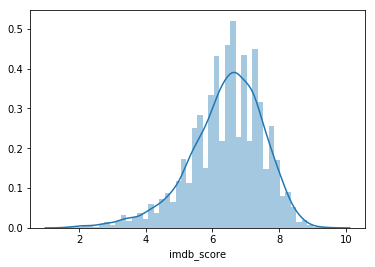

In [50]:
sns.distplot(Mf['imdb_score'])
plt.show()

From the above distribution, I can see that majority of the movies have a pretty average IMDb score between the range of 6-8 skewing slightly to the left but for the most part the ratings are normally distributed so it is a good metric to be used as a target variable if needed to measure popular acclaim.

# Top Rated movies

Now I will look at the top rated movies by the 3 different rating metrics (IMDb score, Rotten Tomatoes score, Metacritic) that we have to see if there are any similarities and differences:

In [51]:
Mf[['movie_title', 'imdb_score', 'Rotten Tomatoes', 'Metacritic', 'title_year',
    'movie_facebook_likes']].sort_values('imdb_score', ascending=False).head(10)

,movie_title,imdb_score,Rotten Tomatoes,Metacritic,title_year,movie_facebook_likes
4626,Towering Inferno,9.5,NaN,NaN,,0.0
693,The Shawshank Redemption,9.3,91.0,80.0,1994,18530780.0
165,The Godfather,9.2,NaN,100.0,1972,43000.0
4540,Kickboxer: Vengeance,9.1,42.0,37.0,2016,0.0
2991,The Dark Knight,9.0,94.0,84.0,2008,37000.0
181,The Godfather: Part II,9.0,97.0,90.0,1974,14000.0
696,Pulp Fiction,8.9,94.0,94.0,1994,45000.0
644,Schindler's List,8.9,97.0,93.0,1993,41000.0
1966,The Lord of the Rings: The Return of the King,8.9,93.0,94.0,2003,960699.0
65,12 Angry Men,8.9,100.0,96.0,1957,40000.0


In [52]:
Mf[['movie_title', 'imdb_score', 'Rotten Tomatoes', 'Metacritic', 'title_year',
    'movie_facebook_likes']].sort_values('Rotten Tomatoes', ascending=False).head(10)

,movie_title,imdb_score,Rotten Tomatoes,Metacritic,title_year,movie_facebook_likes
305,The Ballad of Gregorio Cortez,7.1,100.0,NaN,1982,32.0
4554,Alleluia! The Devil's Carnival,7.4,100.0,NaN,2016,707.0
4097,Butterfly Girl,8.7,100.0,85.0,2014,88.0
1974,Live-In Maid,7.2,100.0,78.0,2004,83.0
43,Red River,7.8,100.0,NaN,1948,6380.0
4000,The Square,8.1,100.0,84.0,2013,0.0
45,Sands of Iwo Jima,7.2,100.0,NaN,1949,2186715.0
46,Annie Get Your Gun,7.0,100.0,77.0,1950,456.0
3508,Sholem Aleichem: Laughing in the Darkness,6.8,100.0,77.0,2011,287.0
2498,The Trials of Darryl Hunt,7.7,100.0,NaN,2006,246.0


In [53]:
Mf[['movie_title', 'imdb_score', 'Rotten Tomatoes', 'Metacritic', 'title_year', 
    'movie_facebook_likes']].sort_values('Metacritic', ascending=False).head(10)

,movie_title,imdb_score,Rotten Tomatoes,Metacritic,title_year,movie_facebook_likes
139,The Conformist,8.1,98.0,100.0,1970,5455.0
165,The Godfather,9.2,NaN,100.0,1972,43000.0
18,The Wizard of Oz,8.1,98.0,100.0,1939,14000.0
85,Lawrence of Arabia,8.4,98.0,100.0,1962,11000.0
4320,Boyhood,8.0,97.0,100.0,2014,92000.0
28,Casablanca,8.6,97.0,100.0,1942,23000.0
52,Singin' in the Rain,8.3,100.0,99.0,1952,0.0
22,Pinocchio,7.5,100.0,99.0,1940,0.0
3,Metropolis,8.3,99.0,98.0,1927,12000.0
695,Hoop Dreams,8.3,98.0,98.0,1994,0.0


To give a little background about the ratings:

__IMDb Score__: IMDb publishes weighted vote averages rather than raw data averages. The simplest way to explain it is that although we accept and consider all votes received by users, not all votes have the same impact (or ‘weight’) on the final rating. Various filters are applied to the raw data in order to eliminate and reduce attempts at vote stuffing by people more interested in changing the current rating of a movie than giving their true opinion of it. In order to ensure that our rating mechanism remains effective, we do not disclose the exact method used to generate the rating. (Source: IMDb)

__Rotten Tomatoes__: The Tomatometer score – based on the opinions of hundreds of film and television critics – is a trusted measurement of critical recommendation for millions of fans. (Source: Rotten Tomatoes)

__Metacritic__: Creating our proprietary Metascores is a complicated process. We carefully curate a large group of the world’s most respected critics, assign scores to their reviews, and apply a weighted average to summarize the range of their opinions. The result is a single number that captures the essence of critical opinion in one Metascore. Each movie, game, television show and album featured on Metacritic gets a Metascore when we've collected at least four critics' reviews. (Source: Metacritic)

Overall, IMDb can be used as a user-influenced popularity metric while Rotten Tomatoes & Metacritic are for critical reviews. Between Rotten Tomatoes & Metacritic, I do not find any top 10 movies that are common signifying the differences in the rating mechanism of both the systems. It is hard to say which is better since we do not know how the weights are calculated behind the scenes. It is also surprising to learn that in both the critical rating metrics, the IMDb scores of the movies are in the range of 7-8 which is average and also the rating for top Rotten tomatoes movies have not very high Metacritic ratings. 

One other column I included is the Movie's facebook likes to see if there is a relationship between the top rated movies and the number of facebook likes it has. It is quite surprising to see that most, if not all, have pretty low numbers and the ones that do have high numbers like 'The Shawshank Redemption' & 'Sands of Iwo Jima' are old movies released in 1994 & 1949 respectively. It would be better to learn how these likes are calculated considering the fact that the newer top rated movies have barely few thousands compared to older movies.

# Number of IMDb users who voted on the score:

In [54]:
Mf['num_voted_users'].describe()

count    4.638000e+03
mean     8.446343e+04
std      1.405189e+05
min      5.000000e+00
25%      8.906250e+03
50%      3.457000e+04
75%      9.603700e+04
max      1.689764e+06
Name: num_voted_users, dtype: float64

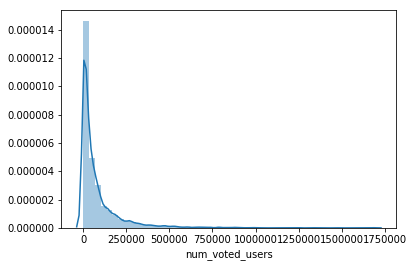

In [55]:
sns.distplot(Mf['num_voted_users'])
plt.show()

In [56]:
Mf[['movie_title', 'num_voted_users', 'title_year']].sort_values('num_voted_users', ascending=False).head(10)

,movie_title,num_voted_users,title_year
693,The Shawshank Redemption,1689764.0,1994
2991,The Dark Knight,1676169.0,2008
3449,Inception,1468200.0,2010
1258,Fight Club,1347461.0,1999
696,Pulp Fiction,1324680.0,1994
694,Forrest Gump,1251222.0,1994
1598,The Lord of the Rings: The Fellowship of the Ring,1238746.0,2001
1249,The Matrix,1217752.0,1999
1966,The Lord of the Rings: The Return of the King,1215718.0,2003
165,The Godfather,1155770.0,1972


The number of users who voted on the score of the movie has an extremely right skewed distribution with mean number being around 84,463 while the median is 34,570 but the maximum number of users goes up to 1,689,764 which shows that the skewness has a huge impact on the mean and most of the number of users lie around the median. I can also see that lot of the movies that show up in the top 10 IMDb ratings also have high number of users voting for them.

# Number of users & critics who reviewed:

In [57]:
Mf['num_user_for_reviews'].describe()

count    4625.000000
mean      273.674595
std       378.433083
min         1.000000
25%        68.000000
50%       159.000000
75%       327.000000
max      5060.000000
Name: num_user_for_reviews, dtype: float64

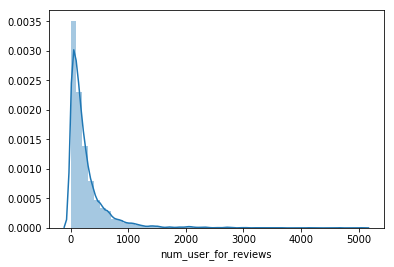

In [58]:
sns.distplot(Mf['num_user_for_reviews'].fillna(Mf['num_user_for_reviews'].median()))
plt.show()

In [59]:
Mf['num_critic_for_reviews'].describe()

count    4602.000000
mean      141.387658
std       121.005632
min         1.000000
25%        52.000000
50%       112.000000
75%       195.000000
max       813.000000
Name: num_critic_for_reviews, dtype: float64

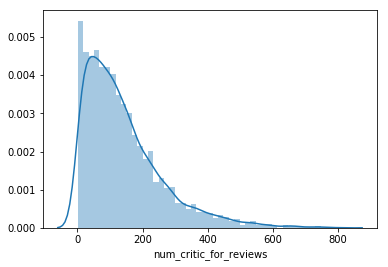

In [60]:
sns.distplot(Mf['num_critic_for_reviews'].fillna(Mf['num_critic_for_reviews'].median()))
plt.show()

From the above plots, I can see that the number of users and critics who review the movies is very highly right skewed with the critic plot having a wider range of numbers and more normality compared to the plot for users. The maximum user reviews for a movie is 5060 which is almost 31 times the median number of reviews while the highest for critics is 813 which is 7 times the median number of reviews so the plot is wider.

# Correlation between Number of users and IMDb rating:

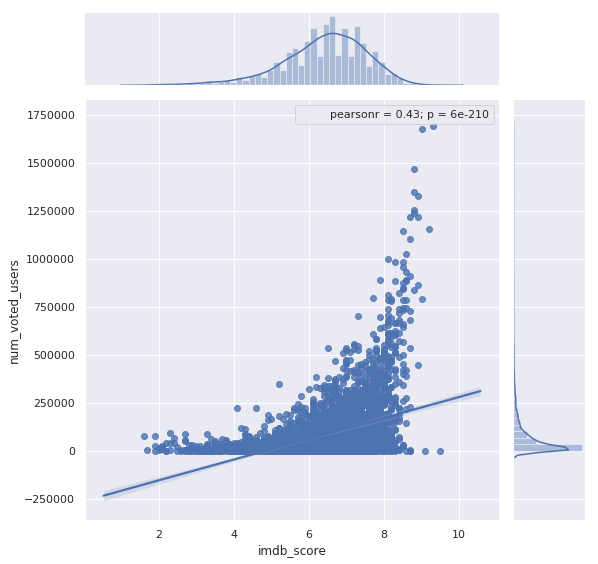

In [61]:
import scipy.stats as stats 
sns.set(style="darkgrid", color_codes=True) 
j = sns.jointplot('imdb_score', 'num_voted_users', data = Mf, kind='reg', height=8) 
j.annotate(stats.pearsonr) 
plt.show()

Looking the correlation between IMDb score and the number of users who voted, there is a 0.43 positive correlation coefficient which is not very high but not low either. So, we do have a positive relationship between the 2 variables.

__Production Houses__:

This is a variable I pulled using the API request. We do not have the values for all the movies but it will be interesting to see which are the top production houses by gross revenue

In [62]:
s = Mf.apply(lambda x: pd.Series(x['Production_house']), axis=1).stack().reset_index(level=1, drop=True)
s.name='companies'

In [63]:
conMf = Mf.drop('Production_house', axis=1).join(s)

In [64]:
con_sum = pd.DataFrame(conMf.groupby('companies')['gross'].sum().sort_values(ascending=False))
con_sum.columns = ['Total']
con_mean = pd.DataFrame(conMf.groupby('companies')['gross'].mean().sort_values(ascending=False))
con_mean.columns = ['Average']
con_count = pd.DataFrame(conMf.groupby('companies')['gross'].count().sort_values(ascending=False))
con_count.columns = ['Number']

con_pivot = pd.concat((con_sum, con_mean, con_count), axis=1)

In [65]:
con_pivot.sort_values('Total', ascending=False).head(10)

,Total,Average,Number
Warner Bros. Pictures,1.997737e+10,7.510290e+07,266
20th Century Fox,1.893422e+10,7.728253e+07,245
Universal Pictures,1.876145e+10,7.534720e+07,249
Paramount Pictures,1.722493e+10,7.901344e+07,218
Walt Disney Pictures,1.051887e+10,1.524475e+08,69
Sony Pictures,8.991862e+09,7.493218e+07,120
Columbia Pictures,5.808528e+09,5.927070e+07,98
New Line Cinema,4.700845e+09,5.165764e+07,91
Buena Vista,4.039053e+09,9.179666e+07,44
Warner Bros.,3.155937e+09,6.188112e+07,51


In [66]:
con_pivot[con_pivot['Number'] >= 15].sort_values('Average', ascending=False).head(10)

,Total,Average,Number
Walt Disney Pictures,1.051887e+10,1.524475e+08,69
Paramount Studios,1.771259e+09,1.107037e+08,16
Dreamworks,2.440984e+09,1.017077e+08,24
Buena Vista,4.039053e+09,9.179666e+07,44
TriStar Pictures,1.273596e+09,8.490640e+07,15
Paramount Pictures,1.722493e+10,7.901344e+07,218
20th Century Fox,1.893422e+10,7.728253e+07,245
DreamWorks SKG,1.694737e+09,7.703351e+07,22
Universal Pictures,1.876145e+10,7.534720e+07,249
Warner Bros. Pictures,1.997737e+10,7.510290e+07,266


Here are some of the top insights:

- Warner Bros Pictures, 20th Century Fox and Universal Pictures are the top production house by total gross revenue across all movies but if we average them out across the number of movies, Walt Disney Pictures, Paramount Studios and Dreamworks rises telling me that they produce lesser movies but which gross higher on average than the top production houses. This could be a factor in predicting a movie's success which I will see later.

- Warner Bros seems to appear twice in the data with 'Warner Bros. Pictures' and 'Warner Bros.' so I will be combining them. 

In [67]:
Mf['Production_house'] = Mf['Production_house'].replace('Warner Bros. Pictures', 'Warner Bros.')

# Month & Weekday of Release

In [68]:
monthorder = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
dayorder = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

In [69]:
Mf['ReleasedDate'] = pd.to_datetime(Mf['ReleasedDate'], errors='coerce')

In [70]:
Mf['Month-str'] = Mf['ReleasedDate'].dt.strftime('%b') 

In [71]:
Mf['Day-str'] = Mf['ReleasedDate'].dt.strftime('%a') 

In [72]:
Mf['Day-str'].head()

0    Sun
1    Fri
2    NaT
3    Sun
4    Thu
Name: Day-str, dtype: object

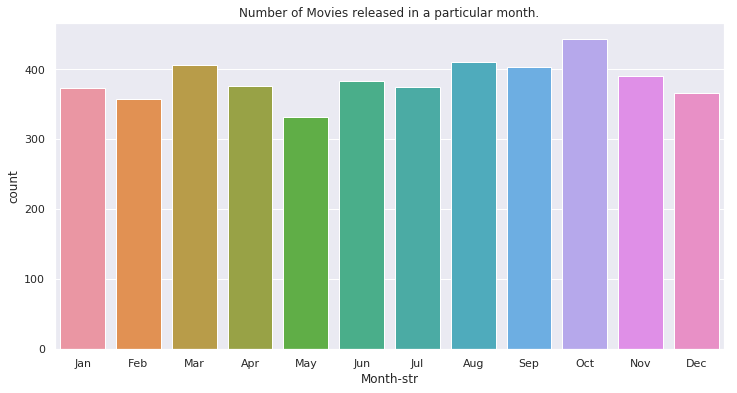

In [73]:
plt.figure(figsize=(12,6))
plt.title("Number of Movies released in a particular month.")
sns.countplot(x='Month-str', data=Mf, order=monthorder)

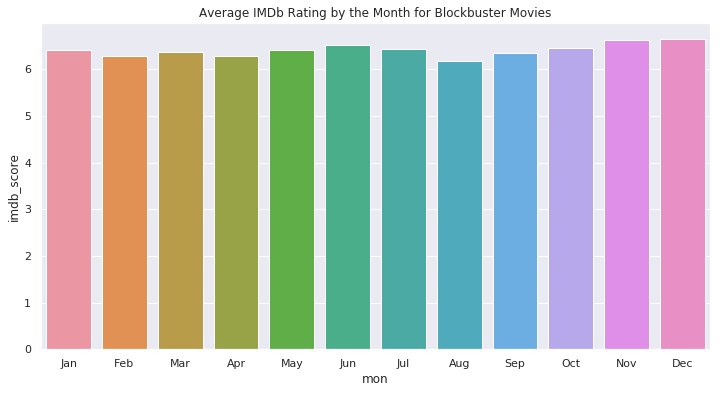

In [74]:
month_mean = pd.DataFrame(Mf.groupby('Month-str')['imdb_score'].mean())
month_mean['mon'] = month_mean.index
plt.figure(figsize=(12,6))
plt.title("Average IMDb Rating by the Month for Blockbuster Movies")
sns.barplot(x='mon', y='imdb_score', data=month_mean, order=monthorder)

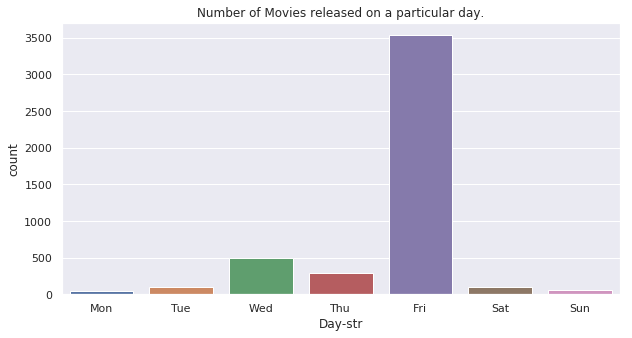

In [75]:
plt.figure(figsize=(10,5))
plt.title("Number of Movies released on a particular day.")
sns.countplot(x='Day-str', data=Mf, order=dayorder)

From above it can be seen that the movies are almost equally distributed across the entire year and the average IMDb rating for these movies is almost the same. Most of the movies release on friday which is quite common but there are some that release on wednesdays as well, this could be paid previews.

In [76]:
Mf['title_year'] = Mf['title_year'].astype(str)

In [77]:
Mf['title_year'] = Mf['title_year'].replace('', np.nan)

__Duration__:

In [78]:
Mf['duration'].describe()

count    4626.000000
mean      108.605491
std        23.382234
min        62.000000
25%        94.000000
50%       104.000000
75%       118.000000
max       511.000000
Name: duration, dtype: float64

In [79]:
Mf['duration'] = Mf['duration'].astype('float')

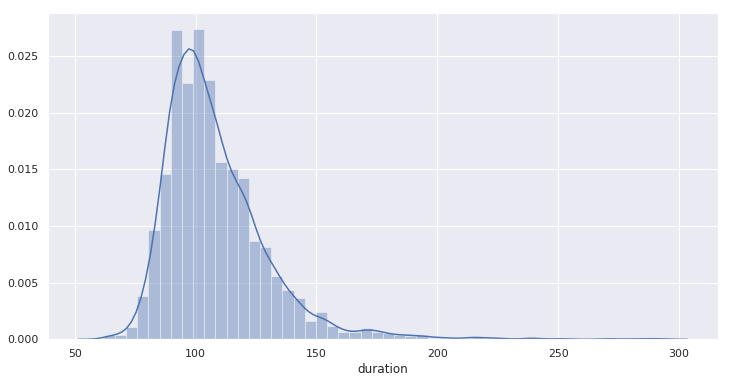

In [80]:
plt.figure(figsize=(12,6))
sns.distplot(Mf[(Mf['duration'] < 300) & (Mf['duration'] > 0)]['duration'])

Look at the duration variable, I can see that it is mostly normally distributed but will seem rightly skewed if seen entirely with all the data points because of few outliers. 

__Budget__:

In [81]:
Mf['budget'].describe()

count    4.262000e+03
mean     3.977903e+07
std      2.125584e+08
min      2.180000e+02
25%      6.000000e+06
50%      2.000000e+07
75%      4.400000e+07
max      1.221550e+10
Name: budget, dtype: float64

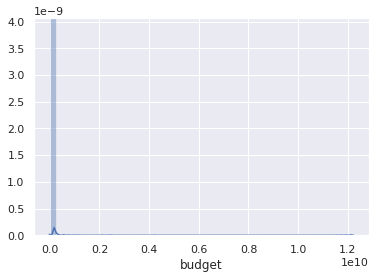

In [82]:
sns.distplot(Mf[Mf['budget'].notnull()]['budget'])

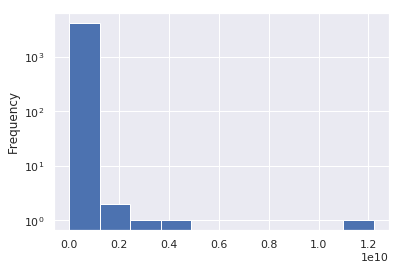

In [83]:
Mf['budget'].plot(logy=True, kind='hist')

Looking at the budget of a movie, it can seen that it is very highly rightly skewed with most of the values lying between 440,000 and 600,000 but the max value is 1,221,550,000 which is a very high number that skews the distribution and the mean

In [84]:
Mf['title_year'] = df['title_year'].replace('NaT', np.nan)

In [85]:
def clean_numeric(x):
    try:
        return float(x)
    except:
        return np.nan

In [86]:
Mf['title_year'] = Mf['title_year'].apply(clean_numeric)

### Investigate Movie and Actor 1 facebook likes:

In [87]:
pearsonr(Mf['movie_facebook_likes'], Mf['actor_1_facebook_likes'])

(0.9999980652480281, 0.0)

In [88]:
Mf[['movie_title', 'movie_facebook_likes', 'actor_1_name', 'prolific_actor_1','actor_1_facebook_likes']]

,movie_title,movie_facebook_likes,actor_1_name,prolific_actor_1,actor_1_facebook_likes
0,Intolerance: Love's Struggle Throughout the Ages,691.0,Lillian Gish,2,436.0
1,Over the Hill to the Poorhouse,0.0,Stephen Carr,1,2.0
2,The Big Parade,226.0,John Gilbert,1,81.0
3,Metropolis,12000.0,Brigitte Helm,1,136.0
4,The Broadway Melody,1718.0,Anita Page,1,1718.0
5,Pandora's Box,926.0,Louise Brooks,1,426.0
6,Hell's Angels,279.0,Jean Harlow,1,431.0
7,A Farewell to Arms,213.0,Gary Cooper,2,998.0
8,She Done Him Wrong,328.0,Mae West,1,418.0
9,42nd Street,3438.0,Ginger Rogers,2,3438.0


In [89]:
Mf[Mf.actor_2_name=='Matthew McConaughey']['actor_2_facebook_likes']

860     11000.0
2448    11000.0
4091    11000.0
Name: actor_2_facebook_likes, dtype: float64

From above, we get the following insights:

- There are a lot of rows where the likes are exactly the same which doesn't make sense
- Taking "Matthew McConaughey" as actor 1 for example since he is a high prolific actor and searching for him as an actor 2, the likes are very different (11,000) compared to (5,209,225) when he is an actor 1.

In [90]:
#Looking at the original dataframe to see if the duplicates have been there since the beginning
duplikes1 = df['movie_facebook_likes'] == df['actor_1_facebook_likes']
df[duplikes1][['movie_title', 'movie_facebook_likes','actor_1_name', 'actor_1_facebook_likes', 
               'title_year', 'genres', 'director_name']].sort_values('movie_facebook_likes', ascending=False)

,movie_title,movie_facebook_likes,actor_1_name,actor_1_facebook_likes,title_year,genres,director_name
4422,The DUFF,9965809,Bella Thorne,9965809,2015,Comedy,Ari Sandel
3137,Forget Me Not,9965809,Bella Thorne,9965809,2009,Horror|Romance|Thriller,Tyler Oliver
4376,Alvin and the Chipmunks: The Road Chip,9965809,Bella Thorne,9965809,2015,Adventure|Animation|Comedy|Family|Fantasy|Music,Walt Becker
4272,Blended,9965809,Bella Thorne,9965809,2014,Comedy|Romance,Frank Coraci
1918,Secondhand Lions,9755,Haley Joel Osment,9755,2003,Comedy|Drama|Family,Tim McCanlies
1804,The Jungle Book 2,9755,Haley Joel Osment,9755,2003,Adventure|Animation|Family|Musical,Steve Trenbirth
827,Bogus,9755,Haley Joel Osment,9755,1996,Comedy|Family|Fantasy,Norman Jewison
1629,The Country Bears,9755,Haley Joel Osment,9755,2002,Comedy|Family|Music|Musical,Peter Hastings
4011,Zulu,960699,Orlando Bloom,960699,2013,Crime|Drama|Thriller,JÃ©rÃ´me Salle
2333,Elizabethtown,960699,Orlando Bloom,960699,2005,Comedy|Drama|Romance,Cameron Crowe


There are 1061 rows out of 4638, which is almost 22.8% of the data where the movie likes and actor 1 likes are exactly the same. Although movie titles are different, it is the places where actors are the same that I notice the likes of the actor and movie are the same. There seems to be no connection to the type of genre the movie is or the director's name.

In [91]:
Mf['movie_facebook_likes'].describe()

count    4.638000e+03
mean     2.557319e+06
std      1.020872e+07
min      0.000000e+00
25%      0.000000e+00
50%      6.165000e+02
75%      2.900000e+04
max      1.012630e+08
Name: movie_facebook_likes, dtype: float64

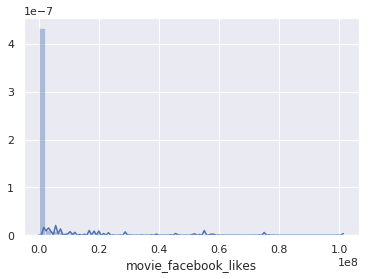

In [92]:
sns.distplot(Mf['movie_facebook_likes'].fillna(Mf['movie_facebook_likes'].median()))
plt.show()

In [93]:
Mf['actor_1_facebook_likes'].describe()

count    4.638000e+03
mean     2.556662e+06
std      1.020888e+07
min      0.000000e+00
25%      6.640000e+02
50%      1.000000e+03
75%      2.200000e+04
max      1.012630e+08
Name: actor_1_facebook_likes, dtype: float64

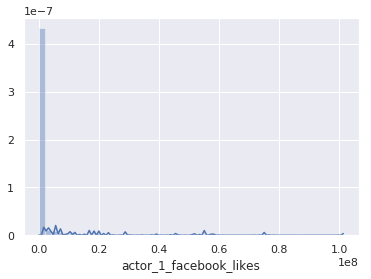

In [94]:
sns.distplot(Mf['actor_1_facebook_likes'].fillna(Mf['actor_1_facebook_likes'].median()))
plt.show()

Looking at the plot and the info, here are the insights:

- The max and mean values of both the variables are exactly the same although the median value differs where for movies it is 616 but for actors it is 1000.
- The distributions look eerily similar.

__Genres__:

In [95]:
Mf['genres'].head()

0    Drama|History|War
1          Crime|Drama
2    Drama|Romance|War
3         Drama|Sci-Fi
4      Musical|Romance
Name: genres, dtype: object

In [96]:
gencount = pd.Series(Mf.genres.str.split('|').sum()).value_counts()

In [97]:
gen1 = pd.DataFrame(gencount.index, columns=['genre'])
gen2 = pd.DataFrame(gencount.values, columns=['movie_count'])
gendf = pd.merge(gen1, gen2, left_index = True, right_index=True)

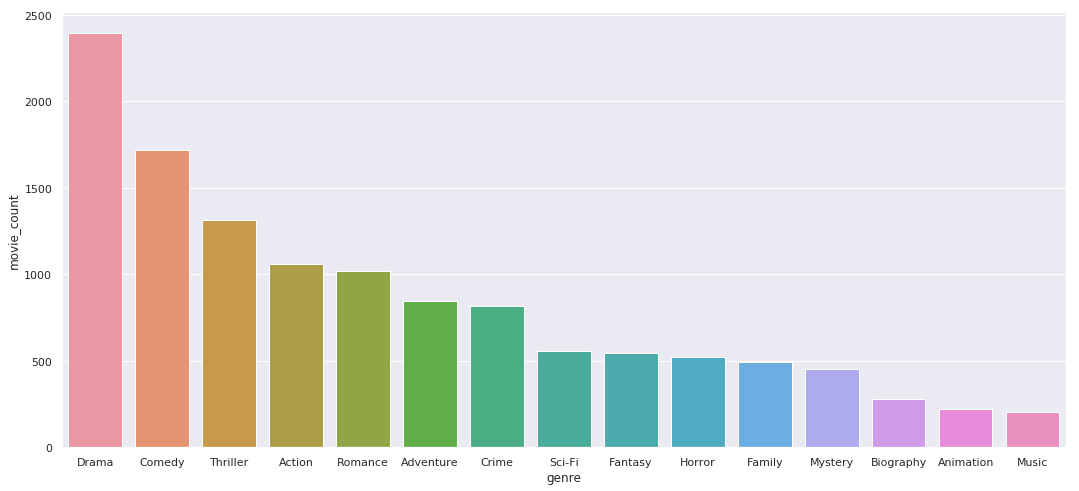

In [98]:
plt.figure(figsize=(18,8))
sns.barplot(x='genre', y='movie_count', data=gendf.head(15))
plt.show()

The top genre is Drama and Comedy. I also see Thriller and Romance among the top 5 confirming the results given by the word cloud regarding the movie titles and the plot keywords.

# Data pre-processing

In [99]:
Mf.loc[Mf['director_facebook_likes'].isnull(),['director_facebook_likes','prolific_director']]

,director_facebook_likes,prolific_director
4627,NaN,0.0
4628,NaN,0.0
4629,NaN,0.0
4630,NaN,0.0
4631,NaN,0.0
4632,NaN,0.0
4633,NaN,0.0
4634,NaN,0.0
4635,NaN,0.0
4637,NaN,0.0


In [100]:
# Director has not made any other movies as the prolific director count is 0. I will replace the null values with 0
Mf['director_facebook_likes'] = Mf['director_facebook_likes'].replace(np.nan,0)

In [101]:
Mf['facenumber_in_poster'] = Mf['facenumber_in_poster'].replace(np.nan,0)

In [102]:
Mf.loc[Mf['title_year'].isnull(),:]

,movie_title,movie_facebook_likes,color,director_name,prolific_director,director_facebook_likes,actor_1_name,actor_2_name,actor_3_name,prolific_actor_1,prolific_actor_2,prolific_actor_3,actor_1_facebook_likes,actor_2_facebook_likes,actor_3_facebook_likes,budget,gross,genres,num_critic_for_reviews,num_voted_users,facenumber_in_poster,plot_keywords,num_user_for_reviews,language,country,content_rating,title_year,imdb_score,oscar_nom_movie,oscar_nom_actor,duration,aspect_ratio,MovieId,Production_house,ReleasedDate,Rotten Tomatoes,Metacritic,Month-str,Day-str
4627,A Touch of Frost,361.0,Color,,0.0,0.0,David Jason,Bruce Alexander,John Lyons,1,1,1,325.0,7.0,5.0,NaN,NaN,Crime|Drama|Mystery,14.0,4438.0,1.0,cult tv|death|detective inspector|four word ti...,33.0,English,UK,Missing,NaN,7.8,0,0,105.0,1.33,tt0108967,None,1992-12-06,NaN,NaN,Dec,Sun
4628,The Streets of San Francisco,533.0,Color,,0.0,0.0,Karl Malden,Michael Douglas,Unknown,5,1,?,416.0,0.0,NaN,NaN,NaN,Action|Crime|Drama|Mystery,13.0,3405.0,0.0,city name in series title|homicide|older man y...,13.0,English,USA,Missing,NaN,7.3,0,3,120.0,4,tt0068135,None,1972-09-16,NaN,NaN,Sep,Sat
4629,Wuthering Heights,0.0,Color,,0.0,0.0,Tom Hardy,Jack O''Connell,Kevin McNally,13,6,8,27000.0,698.0,427.0,NaN,NaN,Drama|Romance,9.0,6053.0,2.0,abuse|love|moor the landscape|revenge|tv mini ...,33.0,English,UK,Missing,NaN,7.7,0,1,142.0,Missing,tt1238834,None,2009-01-18,NaN,NaN,Jan,Sun
4630,Creature,518.0,Color,,0.0,0.0,Craig T. Nelson,Colm Feore,Megalyn Echikunwoke,9,9,3,723.0,539.0,476.0,NaN,NaN,Horror|Sci-Fi|Thriller,10.0,2011.0,3.0,author cameo|family relationships|island|monst...,33.0,English,USA,Missing,NaN,5.0,0,0,173.0,1.78,tt0156205,None,1998-05-17,NaN,NaN,May,Sun
4631,Deadline Gallipoli,367.0,Color,,0.0,0.0,Rachel Griffiths,Jessica De Gouw,Luke Ford,2,1,2,578.0,476.0,110.0,15000000.0,NaN,Drama|War,NaN,299.0,0.0,gallipoli|tv mini series|world war one,1.0,English,Australia,Missing,NaN,7.4,0,1,197.0,Missing,tt3458030,None,2015-04-19,NaN,NaN,Apr,Sun
4632,Emma,0.0,Color,,0.0,0.0,Romola Garai,Blake Ritson,Rupert Evans,4,1,4,805.0,432.0,334.0,NaN,NaN,Comedy|Drama|Romance,10.0,10388.0,1.0,friendship|love triangle|matchmaker|naivety|op...,50.0,English,UK,Missing,NaN,8.2,0,0,240.0,1.78,tt1366312,None,2010-01-24,NaN,NaN,Jan,Sun
4633,The Company,73570.0,Color,,0.0,0.0,Anna Silk,Tom Hollander,Alessandro Nivola,1,4,4,73570.0,555.0,527.0,NaN,NaN,Drama|History|Thriller,9.0,3828.0,3.0,cia|mole|revolution|spy|ussr,39.0,English,USA,Missing,NaN,7.9,0,0,286.0,1.78,tt0488352,None,2007-08-05,NaN,NaN,Aug,Sun
4634,Carlos,0.0,Color,,0.0,0.0,Edgar RamÃ­rez,Nora von WaldstÃ¤tten,Katharina SchÃ¼ttler,8,1,1,897.0,30.0,30.0,NaN,145118.0,Biography|Crime|Drama|Thriller,108.0,10111.0,0.0,opec|pubic hair|revolutionary|terrorism|true c...,36.0,English,France,Unrated,NaN,7.7,0,0,334.0,2.35,tt1321865,None,2010-10-11,NaN,94.0,Oct,Mon
4635,Trapped,0.0,Color,,0.0,0.0,Ãlafur Darri Ãlafsson,Ingvar Eggert SigurÃ°sson,BjÃ¶rn Hlynur Haraldsson,1,2,1,147.0,63.0,51.0,NaN,NaN,Crime|Drama|Thriller,16.0,2308.0,0.0,coastal town|iceland|police|snowstorm|winter s...,19.0,Icelandic,Iceland,Missing,NaN,8.2,0,0,511.0,16,tt3561180,None,2015-12-27,NaN,NaN,Dec,Sun
4636,Star Wars: Episode VII - The Force Awakens,0.0,Missing,Doug Walker,1.0,131.0,Doug Walker,Rob Walker,Unknown,1,1,?,131.0,12.0,NaN,NaN,NaN,Documentary,NaN,8.0,0.0,,NaN,English,USA,Missing,NaN,7.1,0,0,NaN,Missing,tt5289954,None,2015-12-18,NaN,NaN,Dec,Fri


In [103]:
pd.set_option('display.max_rows', 500)
value_title = Mf.groupby(['color'])['title_year'].value_counts(sort = True)
print(value_title)

color             title_year
 Black and White  2004.0         11
                  2006.0         10
                  2002.0          9
                  2003.0          9
                  2001.0          8
                  1999.0          7
                  1998.0          6
                  2005.0          6
                  1962.0          5
                  2000.0          5
                  2009.0          5
                  2012.0          5
                  2013.0          5
                  1964.0          4
                  1993.0          4
                  1994.0          4
                  1995.0          4
                  2007.0          4
                  1940.0          3
                  1961.0          3
                  1980.0          3
                  1991.0          3
                  1929.0          2
                  1933.0          2
                  1936.0          2
                  1938.0          2
                  1939.0          2

In [104]:
# Majority are colors so replacing by maximum movies made in that year, 
Mf['title_year'] = Mf['title_year'].replace(np.nan,2009)

In [105]:
Mf.loc[Mf['duration'].isnull(),:]

,movie_title,movie_facebook_likes,color,director_name,prolific_director,director_facebook_likes,actor_1_name,actor_2_name,actor_3_name,prolific_actor_1,prolific_actor_2,prolific_actor_3,actor_1_facebook_likes,actor_2_facebook_likes,actor_3_facebook_likes,budget,gross,genres,num_critic_for_reviews,num_voted_users,facenumber_in_poster,plot_keywords,num_user_for_reviews,language,country,content_rating,title_year,imdb_score,oscar_nom_movie,oscar_nom_actor,duration,aspect_ratio,MovieId,Production_house,ReleasedDate,Rotten Tomatoes,Metacritic,Month-str,Day-str
1424,Hum To Mohabbat Karega,10.0,Color,Kundan Shah,1.0,4.0,Karisma Kapoor,Bobby Deol,Shakti Kapoor,2,1,1,353.0,89.0,72.0,NaN,NaN,Action|Comedy|Romance|Thriller,1.0,275.0,2.0,elevator|news reporter|police|restaurant|waiter,1.0,Hindi,India,Missing,2000.0,2.8,0,0,NaN,Missing,tt0249588,N/A,2000-05-26,NaN,NaN,May,Fri
2370,Dil Jo Bhi Kahey...,9.0,Color,Romesh Sharma,1.0,0.0,Annabelle Wallis,Revathy,Bhoomika Chawla,2,1,2,421.0,96.0,45.0,70000000.0,129319.0,Romance,4.0,257.0,4.0,,4.0,English,India,Missing,2005.0,5.1,0,0,NaN,Missing,tt0442764,Eros International,2005-09-23,NaN,NaN,Sep,Fri
2599,The Naked Ape,293734.0,Color,Daniel Mellitz,1.0,0.0,Corbin Bernsen,Chelse Swain,Amanda MacDonald,5,1,1,293734.0,36.0,15.0,NaN,NaN,Comedy|Drama,NaN,128.0,0.0,coming of age|male nudity|road trip|skinny dip...,3.0,English,USA,Missing,2006.0,4.7,0,0,NaN,Missing,tt0381053,N/A,2006-09-16,NaN,NaN,Sep,Sat
3237,Black Water Transit,26.0,Color,Tony Kaye,3.0,194.0,Bill Cobbs,Aisha Tyler,Beverly D''Angelo,13,3,10,970.0,856.0,816.0,23000000.0,NaN,Crime|Drama,NaN,219.0,0.0,based on novel,NaN,English,USA,Missing,2009.0,7.2,0,0,NaN,Missing,tt0490087,N/A,2009-05-13,NaN,NaN,May,Wed
3452,N-Secure,588.0,Color,David M. Matthews,1.0,8.0,Essence Atkins,Lamman Rucker,Tempestt Bledsoe,5,2,2,713.0,607.0,394.0,NaN,2592808.0,Crime|Drama|Thriller,5.0,548.0,5.0,betrayal|family relationships|insecurity|murde...,15.0,English,USA,R,2010.0,3.5,0,0,NaN,2.35,tt1289419,Independent Pictures,2010-10-15,NaN,NaN,Oct,Fri
3872,Should've Been Romeo,35.0,Color,Marc Bennett,1.0,3.0,Michael Rapaport,Natasha Henstridge,Costas Mandylor,16,7,9,975.0,900.0,723.0,5000000.0,NaN,Comedy|Drama,2.0,38.0,15.0,,2.0,English,USA,Missing,2012.0,6.7,0,0,NaN,Missing,tt1717210,N/A,2012-04-28,NaN,NaN,Apr,Sat
4092,Barfi,2.0,Color,Shekar,1.0,0.0,Bhama,Diganth,Dileep Raj,1,1,1,5.0,0.0,0.0,NaN,NaN,Comedy|Romance,1.0,57.0,2.0,,1.0,Kannada,India,Missing,2013.0,7.1,0,0,NaN,Missing,tt3099638,N/A,2013-08-30,NaN,NaN,Aug,Fri
4324,Destiny,1873535.0,Color,Joseph Kosinski,3.0,364.0,Peter Dinklage,Lauren Cohan,Erick Avari,13,3,3,1873535.0,4000.0,567.0,NaN,NaN,Action|Adventure|Fantasy|Sci-Fi,4.0,3089.0,0.0,first person shooter,11.0,English,USA,Missing,2014.0,8.1,0,0,NaN,Missing,tt2983582,N/A,2014-09-09,NaN,NaN,Sep,Tue
4529,Karachi se Lahore,259.0,Color,Wajahat Rauf,1.0,3.0,Rasheed Naz,Ayesha Omar,Javed Sheikh,1,1,1,7.0,5.0,4.0,1000000.0,NaN,Comedy|Family,6.0,876.0,9.0,pakistan|road trip,15.0,Urdu,Pakistan,Missing,2015.0,7.0,0,0,NaN,Missing,tt4590482,N/A,2015-11-27,NaN,NaN,Nov,Fri
4530,Romantic Schemer,0.0,Color,Valentine,1.0,0.0,Diane Sorrentino,Valentine,Unknown,1,1,?,17.0,0.0,NaN,125000.0,NaN,Romance,NaN,172.0,2.0,,NaN,English,USA,PG-13,2015.0,5.1,0,0,NaN,Missing,tt4607906,N/A,2015-07-04,NaN,NaN,Jul,Sat


In [106]:
Mf['duration'].describe()

count    4626.000000
mean      108.605491
std        23.382234
min        62.000000
25%        94.000000
50%       104.000000
75%       118.000000
max       511.000000
Name: duration, dtype: float64

In [107]:
Mf['duration'] = Mf['duration'].fillna(Mf['duration'].median())

In [108]:
Mf['Production_house'] = Mf['Production_house'].fillna('Unknown')

In [109]:
Mf.loc[Mf['budget'].isnull(),'genres'].nunique()

169

In [110]:
Mf.groupby('genres')['budget'].mean()

genres
Action                                                          2.068750e+07
Action|Adventure                                                5.998000e+07
Action|Adventure|Animation|Comedy|Crime|Family|Fantasy          7.000000e+07
Action|Adventure|Animation|Comedy|Drama|Family|Sci-Fi           1.175000e+08
Action|Adventure|Animation|Comedy|Family                        1.330000e+08
Action|Adventure|Animation|Comedy|Family|Fantasy                1.037500e+08
Action|Adventure|Animation|Comedy|Family|Fantasy|Sci-Fi         9.200000e+07
Action|Adventure|Animation|Comedy|Family|Sci-Fi                 1.183333e+08
Action|Adventure|Animation|Comedy|Fantasy|Sci-Fi                7.500000e+05
Action|Adventure|Animation|Comedy|Sci-Fi                                 NaN
Action|Adventure|Animation|Drama|Mystery|Sci-Fi|Thriller        3.000000e+07
Action|Adventure|Animation|Family                               9.200000e+07
Action|Adventure|Animation|Family|Fantasy                       8.000

In [111]:
# Replacing budget by mean of the type of genres
Mf['budget'] = Mf.groupby('genres')['budget'].transform(lambda x: x.fillna(x.mean()))

In [112]:
# How many are still having null budget?
print("Total budget missing from the dataset:")
Mf['budget'].isnull().sum()

Total budget missing from the dataset:


39

In [113]:
Mf.loc[Mf['budget'].isnull(),:]

,movie_title,movie_facebook_likes,color,director_name,prolific_director,director_facebook_likes,actor_1_name,actor_2_name,actor_3_name,prolific_actor_1,prolific_actor_2,prolific_actor_3,actor_1_facebook_likes,actor_2_facebook_likes,actor_3_facebook_likes,budget,gross,genres,num_critic_for_reviews,num_voted_users,facenumber_in_poster,plot_keywords,num_user_for_reviews,language,country,content_rating,title_year,imdb_score,oscar_nom_movie,oscar_nom_actor,duration,aspect_ratio,MovieId,Production_house,ReleasedDate,Rotten Tomatoes,Metacritic,Month-str,Day-str
27,Bambi,0.0,Color,James Algar,3.0,11.0,Sam Edwards,Donnie Dunagan,Ann Gillis,1,1,1,16.0,12.0,8.0,NaN,102797150.0,Animation|Drama|Family,116.0,94225.0,0.0,animal|bambi|deer|forest|hunter,136.0,English,USA,Approved,1942.0,7.4,0,0,70.0,1.33,tt0034492,RKO Radio Pictures,1942-08-21,90.0,91.0,Aug,Fri
51,Deadline - U.S.A.,169.0,Black and White,Richard Brooks,4.0,174.0,Humphrey Bogart,Jim Backus,Kim Hunter,2,1,2,2000.0,399.0,114.0,NaN,NaN,Crime|Drama|Film-Noir,27.0,1756.0,0.0,editor|gangster|newspaper|organized crime|press,28.0,English,USA,Missing,1952.0,7.2,0,4,87.0,1.37,tt0044533,20th Century Fox,1952-08-08,NaN,NaN,Aug,Fri
1528,The Caveman's Valentine,1607.0,Color,Kasi Lemmons,3.0,148.0,Colm Feore,Tamara Tunie,Aunjanue Ellis,9,2,4,1607.0,508.0,400.0,NaN,687081.0,Crime|Drama|Music|Mystery|Thriller,58.0,5602.0,0.0,chrysler building manhattan new york city|delu...,59.0,English,USA,R,2001.0,6.0,0,0,105.0,1.85,tt0182000,Universal Pictures,2001-09-20,45.0,44.0,Sep,Thu
1900,Touching the Void,0.0,Color,Kevin Macdonald,3.0,162.0,Nicholas Aaron,Brendan Mackey,Joe Simpson,1,1,1,21.0,5.0,3.0,NaN,4581222.0,Adventure|Documentary|Drama|Sport,121.0,26926.0,0.0,bone|climbing|crevasse|partner|rope,156.0,English,UK,R,2003.0,8.1,0,0,106.0,1.85,tt0379557,IFC Films,2004-03-12,94.0,82.0,Mar,Fri
1996,It's All Gone Pete Tong,0.0,Color,Michael Dowse,2.0,31.0,Paul Kaye,Neil Maskell,Kate Magowan,1,3,1,326.0,246.0,137.0,NaN,120620.0,Biography|Comedy|Drama|Music,58.0,16828.0,1.0,deafness|disappearance|ears|ibiza|musician,67.0,English,UK,R,2004.0,7.4,0,0,90.0,2.35,tt0388139,Matson Films,2005-05-27,76.0,56.0,May,Fri
2079,Riding Giants,0.0,Color,Stacy Peralta,2.0,147.0,Gerry Lopez,Gabrielle Reece,Laird John Hamilton,1,1,1,52.0,52.0,28.0,NaN,2276368.0,Documentary|History|Sport,74.0,3849.0,1.0,beach|surfing|surfing contest|two word title|wave,37.0,English,USA,PG-13,2004.0,7.9,0,0,105.0,Missing,tt0389326,Sony Pictures Classics,2004-08-13,93.0,80.0,Aug,Fri
2096,What the #$*! Do We (K)now!?,162812.0,Black and White,William Arntz,1.0,0.0,Marlee Matlin,Elaine Hendrix,Armin Shimerman,1,6,1,162812.0,670.0,428.0,NaN,10941801.0,Comedy|Documentary|Drama|Fantasy|Mystery|Sci-Fi,74.0,12059.0,0.0,consciousness|photographer|radical|science|sci...,486.0,English,USA,Unrated,2004.0,5.4,0,1,109.0,1.85,tt0399877,Lord of the Wind,2004-10-22,34.0,38.0,Oct,Fri
2179,Supercross,19890072.0,Color,Steve Boyum,2.0,9.0,Channing Tatum,Mike Vogel,Steve Howey,21,7,5,19890072.0,2000.0,826.0,NaN,3101301.0,Action|Drama|Romance|Sport,41.0,3926.0,1.0,one word title|paddock|supercross|swimming poo...,38.0,English,USA,PG-13,2005.0,4.0,0,0,80.0,1.85,tt0403016,20th Century Fox,2005-08-17,5.0,26.0,Aug,Wed
2264,Racing Stripes,771.0,Color,Frederik Du Chau,2.0,7.0,Bruce Greenwood,Frankie Muniz,M. Emmet Walsh,19,7,8,984.0,934.0,521.0,NaN,49186871.0,Adventure|Comedy|Drama|Family|Sport,73.0,12570.0,0.0,farm|horse|kentucky|racehorse|zebra,86.0,English,USA,PG,2005.0,5.2,0,0,102.0,1.85,tt0376105,Warner Bros.,2005-01-14,35.0,43.0,Jan,Fri
2280,Mad Hot Ballroom,588.0,Color,Marilyn Agrelo,1.0,2.0,Heather Berman,Eva Carrozza,Paul Daggett,1,1,1,0.0,0.0,0.0,NaN,8044906.0,Documentary|Family|Music,84.0,3156.0,2.0,ballroom dancing|new york city|poise|self conf...,65.0,English,USA,PG,2005.0,7.5,0,0,105.0,1.85,tt0438205,Paramount Classics,2005-07-01,84.0,71.0,Jul,Fri


In [114]:
Mf['genre'] = Mf['genres'].str.split('|').str.get(0)
Mf.head()

,movie_title,movie_facebook_likes,color,director_name,prolific_director,director_facebook_likes,actor_1_name,actor_2_name,actor_3_name,prolific_actor_1,prolific_actor_2,prolific_actor_3,actor_1_facebook_likes,actor_2_facebook_likes,actor_3_facebook_likes,budget,gross,genres,num_critic_for_reviews,num_voted_users,facenumber_in_poster,plot_keywords,num_user_for_reviews,language,country,content_rating,title_year,imdb_score,oscar_nom_movie,oscar_nom_actor,duration,aspect_ratio,MovieId,Production_house,ReleasedDate,Rotten Tomatoes,Metacritic,Month-str,Day-str,genre
0,Intolerance: Love's Struggle Throughout the Ages,691.0,Black and White,D.W. Griffith,1.0,204.0,Lillian Gish,Mae Marsh,Walter Long,2,1,1,436.0,22.0,9.0,385907.0,NaN,Drama|History|War,69.0,10718.0,1.0,huguenot|intolerance|medicis|protestant|wedding,88.0,None,USA,Unrated,1916.0,8.0,0,1,123.0,1.33,tt0006864,Cohen Media Group,1918-02-24,97.0,NaN,Feb,Sun,Drama
1,Over the Hill to the Poorhouse,0.0,Black and White,Harry F. Millarde,1.0,0.0,Stephen Carr,Johnnie Walker,Mary Carr,1,1,1,2.0,2.0,0.0,100000.0,3000000.0,Crime|Drama,1.0,5.0,1.0,family relationships|gang|idler|poorhouse|thief,1.0,None,USA,Missing,1920.0,4.8,0,0,110.0,1.33,tt0011549,N/A,1920-09-17,NaN,NaN,Sep,Fri,Crime
2,The Big Parade,226.0,Black and White,King Vidor,3.0,54.0,John Gilbert,RenÃ©e AdorÃ©e,Claire Adams,1,1,1,81.0,12.0,6.0,245000.0,NaN,Drama|Romance|War,48.0,4849.0,0.0,chewing gum|climbing a tree|france|translation...,45.0,None,USA,Unrated,1925.0,8.3,0,0,151.0,1.33,tt0015624,MGM,NaT,100.0,NaN,NaT,NaT,Drama
3,Metropolis,12000.0,Black and White,Fritz Lang,1.0,756.0,Brigitte Helm,Gustav FrÃ¶hlich,Rudolf Klein-Rogge,1,1,1,136.0,23.0,18.0,6000000.0,26435.0,Drama|Sci-Fi,260.0,111841.0,1.0,art deco|bible quote|dance|silent film|worker,413.0,German,Germany,Unrated,1927.0,8.3,0,0,145.0,1.33,tt0017136,Paramount Pictures,1927-03-13,99.0,98.0,Mar,Sun,Drama
4,The Broadway Melody,1718.0,Black and White,Harry Beaumont,1.0,4.0,Anita Page,Bessie Love,Charles King,1,1,1,1718.0,28.0,4.0,379000.0,2808000.0,Musical|Romance,36.0,4546.0,8.0,sibling rivalry|singer|sister act|whistling|wi...,71.0,English,USA,PG,1929.0,6.3,2,1,100.0,1.37,tt0019729,MGM Home Entertainment,1929-06-06,35.0,NaN,Jun,Thu,Musical


In [115]:
# replacing other 39 columns by genre 
Mf['budget'] = Mf.groupby('genre')['budget'].transform(lambda x: x.fillna(x.mean()))

In [116]:
Mf.loc[Mf['budget'].isnull(),:]

,movie_title,movie_facebook_likes,color,director_name,prolific_director,director_facebook_likes,actor_1_name,actor_2_name,actor_3_name,prolific_actor_1,prolific_actor_2,prolific_actor_3,actor_1_facebook_likes,actor_2_facebook_likes,actor_3_facebook_likes,budget,gross,genres,num_critic_for_reviews,num_voted_users,facenumber_in_poster,plot_keywords,num_user_for_reviews,language,country,content_rating,title_year,imdb_score,oscar_nom_movie,oscar_nom_actor,duration,aspect_ratio,MovieId,Production_house,ReleasedDate,Rotten Tomatoes,Metacritic,Month-str,Day-str,genre
3927,Metallica Through the Never,19000.0,Color,NimrÃ³d Antal,3.0,190.0,James Hetfield,Mackenzie Gray,Lars Ulrich,1,2,1,364.0,253.0,151.0,NaN,3419967.0,Music,103.0,13359.0,0.0,headbanger|metallica|roadie|song in title|stan...,56.0,English,USA,R,2013.0,7.2,0,0,93.0,2.35,tt2172935,Picturehouse Films,2013-10-04,79.0,61.0,Oct,Fri,Music
4359,America Is Still the Place,337.0,Color,Patrick Gilles,1.0,0.0,Emma Caulfield,Dylan Baker,Mike Colter,2,10,3,970.0,812.0,569.0,NaN,NaN,History,NaN,22.0,0.0,,NaN,English,USA,Missing,2015.0,7.5,0,0,90.0,Missing,tt3417110,N/A,2015-03-01,NaN,NaN,Mar,Sun,History


In [117]:
Mf.budget.describe()

count    4.636000e+03
mean     3.887197e+07
std      2.040717e+08
min      2.180000e+02
25%      7.000000e+06
50%      1.934288e+07
75%      4.000000e+07
max      1.221550e+10
Name: budget, dtype: float64

In [118]:
# replacing other 2 columns by min of budget as music movies are very less as seen from the graph
Mf['budget'] = Mf.budget.transform(lambda x: x.fillna(x.min()))

Text(0, 0.5, 'Frequency')

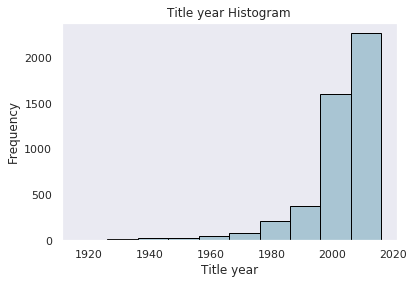

In [119]:
fig, ax = plt.subplots()
Mf['title_year'].hist(color='#A9C5D3', edgecolor='black',  
                          grid=False)
ax.set_title('Title year Histogram', fontsize=12)
ax.set_xlabel('Title year', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)

Most of the movie production increased in later years that is why the histogram is left skewed

In [120]:
Mf.titleyear_log = np.log(Mf['title_year'] + 1)
Mf.titleyear_log.describe()

count    4638.000000
mean        7.602600
std         0.006268
min         7.558517
25%         7.600902
50%         7.603898
75%         7.606885
max         7.609367
Name: title_year, dtype: float64

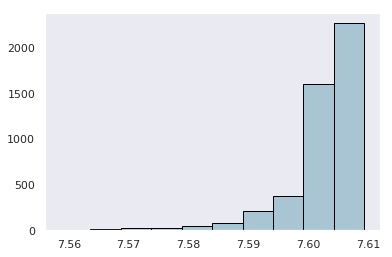

In [121]:
fig, ax = plt.subplots()
Mf.titleyear_log.hist(color='#A9C5D3', edgecolor='black',  
                          grid=False)

In [122]:
Mf['aspect_ratio'] = Mf.aspect_ratio.replace('Missing','0')

In [123]:
# if language is English then 1 else foriegn language is 0
Mf["English_language"] = np.where(Mf["language"].str.contains("English"), 1, 0)

In [124]:
# Label Encoder for following features
gen_ord_map = {'R': 1, 'PG-13': 2, 'PG': 3, 
               'Missing': 4, 'Unrated': 4, 'G': 6, 'Approved': 7, 'X': 8, 'NC-17': 9}
Mf['content_rating_label'] = Mf.content_rating.map(gen_ord_map)

In [125]:
from sklearn.preprocessing import LabelEncoder
gen_le = LabelEncoder()
gen_labels = gen_le.fit_transform(Mf['Production_house'])
Mf['Production_house_label'] = gen_labels

In [126]:
Mf = pd.get_dummies(Mf, columns =['color','Month-str'])

In [127]:
Mf['titleyear_log'] = Mf['title_year'].apply(np.log)

In [128]:
Mf.columns

Index(['movie_title', 'movie_facebook_likes', 'director_name',
       'prolific_director', 'director_facebook_likes', 'actor_1_name',
       'actor_2_name', 'actor_3_name', 'prolific_actor_1', 'prolific_actor_2',
       'prolific_actor_3', 'actor_1_facebook_likes', 'actor_2_facebook_likes',
       'actor_3_facebook_likes', 'budget', 'gross', 'genres',
       'num_critic_for_reviews', 'num_voted_users', 'facenumber_in_poster',
       'plot_keywords', 'num_user_for_reviews', 'language', 'country',
       'content_rating', 'title_year', 'imdb_score', 'oscar_nom_movie',
       'oscar_nom_actor', 'duration', 'aspect_ratio', 'MovieId',
       'Production_house', 'ReleasedDate', 'Rotten Tomatoes', 'Metacritic',
       'Day-str', 'genre', 'English_language', 'content_rating_label',
       'Production_house_label', 'color_ Black and White', 'color_Color',
       'color_Missing', 'Month-str_Apr', 'Month-str_Aug', 'Month-str_Dec',
       'Month-str_Feb', 'Month-str_Jan', 'Month-str_Jul', 'Month-s

In [129]:
Mf2 = Mf.drop(['movie_title', 'movie_facebook_likes', 'director_name', 'director_facebook_likes',
              'actor_1_name', 'actor_2_name', 'actor_3_name', 'actor_1_facebook_likes',
              'actor_2_facebook_likes', 'actor_3_facebook_likes', 'num_critic_for_reviews', 'gross',
              'num_voted_users', 'plot_keywords', 'num_user_for_reviews', 'title_year', 'oscar_nom_movie', 
              'oscar_nom_actor', 'MovieId', 'ReleasedDate', 'Rotten Tomatoes', 'Metacritic', 'gross', 
              'country', 'Day-str', 'language', 'content_rating', 'Production_house'], axis=1)

In [130]:
Mf2.columns

Index(['prolific_director', 'prolific_actor_1', 'prolific_actor_2',
       'prolific_actor_3', 'budget', 'genres', 'facenumber_in_poster',
       'imdb_score', 'duration', 'aspect_ratio', 'genre', 'English_language',
       'content_rating_label', 'Production_house_label',
       'color_ Black and White', 'color_Color', 'color_Missing',
       'Month-str_Apr', 'Month-str_Aug', 'Month-str_Dec', 'Month-str_Feb',
       'Month-str_Jan', 'Month-str_Jul', 'Month-str_Jun', 'Month-str_Mar',
       'Month-str_May', 'Month-str_NaT', 'Month-str_Nov', 'Month-str_Oct',
       'Month-str_Sep', 'titleyear_log'],
      dtype='object')

In [131]:
gen_dum = Mf2['genres'].str.get_dummies(sep='|')

Mf3 = pd.concat([Mf2, gen_dum], axis=1)

In [132]:
Mf3.columns

Index(['prolific_director', 'prolific_actor_1', 'prolific_actor_2',
       'prolific_actor_3', 'budget', 'genres', 'facenumber_in_poster',
       'imdb_score', 'duration', 'aspect_ratio', 'genre', 'English_language',
       'content_rating_label', 'Production_house_label',
       'color_ Black and White', 'color_Color', 'color_Missing',
       'Month-str_Apr', 'Month-str_Aug', 'Month-str_Dec', 'Month-str_Feb',
       'Month-str_Jan', 'Month-str_Jul', 'Month-str_Jun', 'Month-str_Mar',
       'Month-str_May', 'Month-str_NaT', 'Month-str_Nov', 'Month-str_Oct',
       'Month-str_Sep', 'titleyear_log', 'Action', 'Adventure', 'Animation',
       'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family',
       'Fantasy', 'Film-Noir', 'History', 'Horror', 'Music', 'Musical',
       'Mystery', 'News', 'Romance', 'Sci-Fi', 'Sport', 'Thriller', 'War',
       'Western'],
      dtype='object')

In [133]:
Mf3 = Mf3.drop(['genres', 'genre'], axis=1)

In [134]:
Mf3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4638 entries, 0 to 4637
Data columns (total 52 columns):
prolific_director         4638 non-null float64
prolific_actor_1          4638 non-null object
prolific_actor_2          4638 non-null object
prolific_actor_3          4638 non-null object
budget                    4638 non-null float64
facenumber_in_poster      4638 non-null float64
imdb_score                4638 non-null float64
duration                  4638 non-null float64
aspect_ratio              4638 non-null object
English_language          4638 non-null int64
content_rating_label      4638 non-null int64
Production_house_label    4638 non-null int64
color_ Black and White    4638 non-null uint8
color_Color               4638 non-null uint8
color_Missing             4638 non-null uint8
Month-str_Apr             4638 non-null uint8
Month-str_Aug             4638 non-null uint8
Month-str_Dec             4638 non-null uint8
Month-str_Feb             4638 non-null uint8
Month

In [135]:
Mf3['prolific_actor_1'] = Mf3['prolific_actor_1'].str.replace('?','0') 
Mf3['prolific_actor_1'] = Mf3['prolific_actor_1'].str.replace('  ?','0')
Mf3['prolific_actor_1'].unique()

array(['2', '1', '3', '5', '6', '4', '9', '24', '7', '8', '14', '16',
       '10', '15', '11', '12', '21', '29', '53', '26', '31', '30', '23',
       '13', '28', '32', '00', '33', '17', '19', '27', '43', '38', '18',
       '22', '20', '25', '37', '0'], dtype=object)

In [136]:
Mf3['prolific_actor_2'] = Mf3['prolific_actor_2'].str.replace('?','0')
Mf3['prolific_actor_2'] = Mf3['prolific_actor_2'].str.replace('  ?','0')
Mf3['prolific_actor_2'].unique()

array(['1', '3', '2', '4', '5', '8', '6', '12', '9', '7', '21', '11',
       '10', '26', '16', '17', '13', '30', '19', '14', '38', '15', '43',
       '24', '20', '27', '00', '31', '28', '33', '22', '53', '37', '32',
       '23', '25', '18', '29', '0'], dtype=object)

In [137]:
Mf3['prolific_actor_3'] = Mf3['prolific_actor_3'].str.replace('?','0')
Mf3['prolific_actor_3'] = Mf3['prolific_actor_3'].str.replace('  ?','0')
Mf3['prolific_actor_3'].unique()

array(['1', '2', '3', '4', '00', '5', '7', '6', '10', '0', '24', '11',
       '9', '8', '13', '15', '28', '14', '12', '16', '21', '19', '26',
       '17', '27', '20', '23', '37', '32', '43', '22', '33', '18', '30',
       '38', '29', '31'], dtype=object)

## Success Metric Definition:

In [138]:
def classify(col):
    if col['imdb_score'] >= 0 and col['imdb_score'] < 6:
        return 0
    elif col['imdb_score'] >= 6 and col['imdb_score'] < 7.3:
        return 1
    elif col['imdb_score'] >= 7.3 and col['imdb_score'] <= 10:
        return 2

In [139]:
Mf3['Success'] = Mf3.apply(classify, axis=1)

In [140]:
Mf5 = Mf3.drop('imdb_score', axis = 1)

In [141]:
# Standardize the data attributes
# separate the data and target attributes
X = Mf5.drop(['Success'], axis = 1)
y = Mf5.Success
# standardize the data attributes
standardized_X = preprocessing.scale(X)

In [142]:
X_train, X_test, y_train, y_test = train_test_split(standardized_X, y, test_size = 0.20, random_state=90)

In [143]:
y_train.mean(),y_test.mean()

(0.9296495956873315, 0.9385775862068966)

## Model Creation & Application

In [144]:
# GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier as xgb
reg =  xgb(learning_rate=0.05, n_estimators=300, max_depth=3, subsample= 0.5)
reg.fit(X_train, y_train)
reg.score(X_test, y_test)

0.603448275862069

In [145]:
# Predicting on test data
Ypredict = np.exp(reg.predict(X_test))

In [146]:
feature_importance_model = reg.feature_importances_

## Feature Engineering

In [147]:
pd.DataFrame(sorted(dict(zip(X.columns,feature_importance_model)).items(), key = lambda x : x[1], reverse= True))

,0,1
0,duration,0.178445
1,budget,0.111774
2,titleyear_log,0.087859
3,Production_house_label,0.075441
4,prolific_director,0.065857
5,prolific_actor_1,0.050715
6,Drama,0.043402
7,prolific_actor_2,0.040474
8,prolific_actor_3,0.030940
9,content_rating_label,0.030652


In [148]:
# Logisticregression
model =  LogisticRegressionCV()
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.5743534482758621

In [149]:
#classification report
ytest_predict = model.predict(X_test)
print(classification_report(y_true=y_test,y_pred=ytest_predict))

              precision    recall  f1-score   support

           0       0.65      0.47      0.55       287
           1       0.52      0.77      0.62       411
           2       0.70      0.35      0.47       230

   micro avg       0.57      0.57      0.57       928
   macro avg       0.63      0.53      0.55       928
weighted avg       0.61      0.57      0.56       928



In [150]:
#RandomForestClassifier

random =  RandomForestClassifier(n_estimators=50, max_depth=3)
random.fit(X_train, y_train)
random.score(X_test, y_test)

0.46228448275862066

In [151]:
movie_title = Mf[['movie_title']]

In [152]:
#applying reg variable which is GradientBoostingclassifier 
predict = pd.DataFrame(reg.predict(standardized_X), columns= ['Predicted_rating'])    # Predictions on the test set
submission = pd.concat([movie_title, predict],axis =1)

In [153]:
submission['Predicted_rating'].value_counts()

1    2741
0    1182
2     715
Name: Predicted_rating, dtype: int64

## Output a database file with the predictions

In [154]:
submission.to_sql('movieprediction', conn, if_exists='replace', index=False)

In [155]:
pd.read_sql('select * from movieprediction', conn)

,movie_title,Predicted_rating
0,Intolerance: Love's Struggle Throughout the Ages,2
1,Over the Hill to the Poorhouse,2
2,The Big Parade,2
3,Metropolis,2
4,The Broadway Melody,1
5,Pandora's Box,2
6,Hell's Angels,2
7,A Farewell to Arms,1
8,She Done Him Wrong,1
9,42nd Street,2


In [156]:
conn.commit()

In [157]:
conn.close()